In [1]:
# Imports
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fnmatch import fnmatch
from pathlib import Path

from skimage.measure import label
from skimage.measure import regionprops_table, regionprops
from skimage.filters import threshold_otsu
from skimage.io import imread, imshow
from skimage.segmentation import relabel_sequential
from skimage.morphology import binary_closing, binary_dilation, remove_small_objects
from skimage.transform import resize

from sklearn.neighbors import KDTree

from scipy.spatial import cKDTree
from stardist import fill_label_holes, random_label_cmap
import math
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import imageio as iio
from tqdm import tqdm
import cv2
import tifffile as tfile

In [6]:
import skimage

In [7]:
skimage.__version__

'0.21.0'

In [1]:
import sklearn

In [2]:
sklearn.__version__

'1.3.1'

In [4]:
import seaborn

In [5]:
seaborn.__version__

'0.13.0'

In [2]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

## Fiji Macro creates the following file structure:
- C1
- C2
- ROI
- Masks
- Original
- Output_FIJI

## Please put in your parameters here:

In [3]:
filepath = r"D:\PROJECTS\Gerke\NIKITA\_FROMSARAH_IMAGEANALYSIS\TEST NIKITA ALL" # Filepath where OUTPUT of macro is saved

# Channel 1 - Amph1
thresh_C1 = 0.5 # This is the threshold for the probability maps. You can use the same threshold you used in the previous experiments
filter_minsize_C1 = 0.01 # size filter for punctae in um^2
filter_maxsize_C1 = 5 # size filter for punctae in um^2

# Channel 2 - TfR
thresh_C2 = 0.5 # This is the threshold for the probability maps. You can use the same threshold you used in the previous experiments
filter_minsize_C2 = 0.05 # size filter for punctae in um^2
filter_maxsize_C2 = 5 # size filter for punctae in um^2

#Saving options. CAREFUL, setting saving options to "True" will increase the running duration a lot (2-3 hours for full dataset)!
save_segmentation = False
save_segmentation_filtered = False
save_overlayNN = False

In [4]:
def mask_probability_image(prob_img, mask):
    if prob_img.shape != mask.shape:
        mask = resize(mask, prob_img.shape, preserve_range=True)
    assert prob_img.shape == mask.shape
    
    return prob_img * mask / 255


def threshold_probability_image(prob_img, thresh_C1=0.4, thresh_C2=0.4):
   
    return np.stack((prob_img[0, :, :, :] >= thresh_C1, prob_img[1, :, :, :] >= thresh_C2), axis=0)


def create_label_imgs(bin_img):
    label_imgs = []
    ch1 = bin_img[0, :,  :, :]
    ch2 = bin_img[1, :,  :, :]

    
    for frame in range(ch1.shape[0]):
        label_img = label(ch1[frame, :, :], background=0, connectivity=1)
        #label_img = remove_small_objects(label_img, 5)
        label_img = fill_label_holes(label_img)
        label_imgs.append(label_img)
        
    lbl_C1 = np.array(label_imgs)

    label_imgs = []
    for frame in range(ch2.shape[0]):
        label_img = label(ch2[frame, :, :], background=0, connectivity=1)
        label_img = remove_small_objects(label_img, 5)
        label_img = fill_label_holes(label_img)
        label_imgs.append(label_img)

    lbl_C2 = np.array(label_imgs)
    lbl = np.concatenate([np.expand_dims(lbl_C1, 0), np.expand_dims(lbl_C2, 0)], axis=0)

    return lbl


def get_label_props(lbl):
    label_props = {}
    props = {}
    for frame in range(lbl.shape[1]):
        props_C1 = regionprops_table(lbl[0, frame, :, :], properties=("label", "bbox", "centroid", "area"), spacing = (0.085, 0.085)) #spacing = (0.085, 0.085)
        props_C2 = regionprops_table(lbl[1, frame, :, :], properties=("label", "bbox", "centroid", "area"), spacing = (0.085, 0.085)) #spacing = (0.085, 0.085)
        props = {}
        props["C1"] = props_C1
        props["C2"] = props_C2
        label_props[frame] = props

    return label_props

## Start of the analysis:

In [5]:
# Load wound position file

ROIs = []
roi_folder = filepath + "/Output_FIJI"
pattern = "*ROICoordinates.csv"

for name in os.listdir(roi_folder):
    if fnmatch(name, pattern):
        #print(name)
        rois = pd.read_csv(filepath + "/Output_FIJI/" + name, delimiter=",")
        rois["Identifier"] = name.split(" ROIROI")[0]
        rois["Circle"] = np.arange(0, rois.shape[0], 1)
        ROIs.append(rois)

df_ROIs = pd.concat(ROIs)

In [6]:
# Open all Masks
masks = []
mask_folder = filepath + "/Output_FIJI"
pattern = "*_Mask.tiff"

for name in os.listdir(mask_folder):
    if fnmatch(name, pattern):
        #print(name)
        mask = imread(os.path.join(mask_folder, name))
        mask = mask[:, 0, :, :]
        mask = np.expand_dims(mask, 1)
        mask = np.repeat(mask, 2, axis=1)
        mask = np.moveaxis(mask, 0, 1)     
        masks.append(mask)

In [7]:
# Open all images
imgs, identifiers = [], []
C1_folder = filepath + "/C1"
C2_folder = filepath + "/C2"

for name in os.listdir(C1_folder):
    img_C1 = imread(os.path.join(C1_folder, name))
    name_C2 = "C2-" + name.split("C1-")[-1]
    img_C2 = imread(os.path.join(C2_folder, name_C2))
    imgs.append(np.concatenate([np.expand_dims(img_C1, 0),np.expand_dims(img_C2, 0)]))
    identifiers.append(name.split("C1-")[1].split(" ROI.tif")[0])

In [8]:
## Check if all data is there
assert len(masks) == len(imgs)

### 2. Data analysis

In [9]:
# Mask and theshold your image to create binary images
binary_imgs = []
for i in range(len(imgs)):
    prob_img = mask_probability_image(imgs[i], masks[i])
    bin_img = threshold_probability_image(prob_img, thresh_C1, thresh_C2)
    binary_imgs.append(bin_img)

In [10]:
lbl_imgs = []

for i in tqdm(range(len(binary_imgs))):
    lbl_img = create_label_imgs(binary_imgs[i])
    lbl_imgs.append(lbl_img)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [03:21<00:00,  9.60s/it]


In [11]:
#Save segmentation images

if save_segmentation:
    print("Saving label images.")
    for number, lbl_image in tqdm(enumerate(lbl_imgs)):
        newpath = filepath + f"/{identifiers[number]}_Labels"
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        tiffname = newpath + f"/_label.tiff"
        tfile.imwrite(tiffname, lbl_image[:, :, :, :])

In [12]:
lbl_props = []

for i in tqdm(range(len(lbl_imgs))):
    lbl_prop =get_label_props(lbl_imgs[i])
    lbl_props.append(lbl_prop)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:35<00:00,  4.53s/it]


In [13]:
list_lbl_props_C1 = []
list_lbl_props_C2 = []
    
for i in range(len(lbl_props)):
    dfs_C1, dfs_C2 = [], []
    for frame in range(len(lbl_props[i])):
        df_C1_ = pd.DataFrame.from_dict(lbl_props[i][frame]["C1"])
        df_C1_["frame"]= frame+1
        dfs_C1.append(df_C1_)
    for frame in range(len(lbl_props[i])):
        df_C2_ = pd.DataFrame.from_dict(lbl_props[i][frame]["C2"])
        df_C2_["frame"]= frame+1
        dfs_C2.append(df_C2_)

    df_C1 = pd.concat(dfs_C1, axis=0, ignore_index=True)
    df_C1["Identifier"] = identifiers[i]
    df_C1["Wound_coord_X"] = ROIs[i].iloc[0, 3]
    df_C1["Wound_coord_Y"] = ROIs[i].iloc[0, 4]
    df_C2 = pd.concat(dfs_C2, axis=0, ignore_index=True)
    df_C2["Wound_coord_X"] = ROIs[i].iloc[0, 3]
    df_C2["Wound_coord_Y"] = ROIs[i].iloc[0, 4]
    df_C2["Identifier"] = identifiers[i]

    list_lbl_props_C1.append(df_C1)
    list_lbl_props_C2.append(df_C2)

df_lbl_props_C1 = pd.concat(list_lbl_props_C1, axis=0, ignore_index=True)
df_lbl_props_C2 = pd.concat(list_lbl_props_C2, axis=0, ignore_index=True)

In [14]:
df_lbl_props_C1.to_csv(filepath+"\\"+"C1_punctaedata.csv")
df_lbl_props_C2.to_csv(filepath+"\\"+"C2_punctaedata.csv")

<Figure size 1200x600 with 0 Axes>

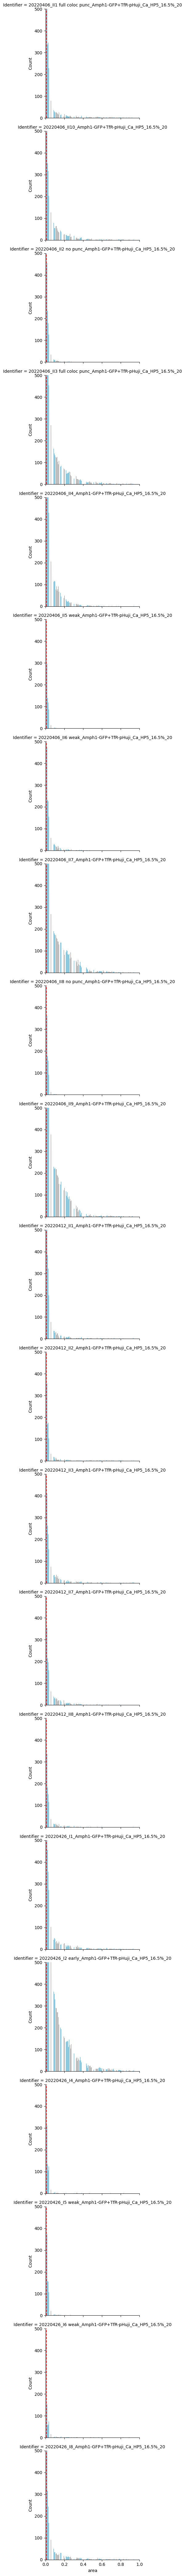

In [15]:
# Plot punctae sizes - Histogram - Amph1
plt.figure(figsize=(12, 6))
g = sns.displot(df_lbl_props_C1, x="area", row="Identifier", height=4)
g.refline(x=filter_minsize_C1, color="red")
g.refline(x=filter_maxsize_C1, color="red")
g.set(xlim=(0,1))
g.set(ylim=(0, 500))

<Figure size 1200x600 with 0 Axes>

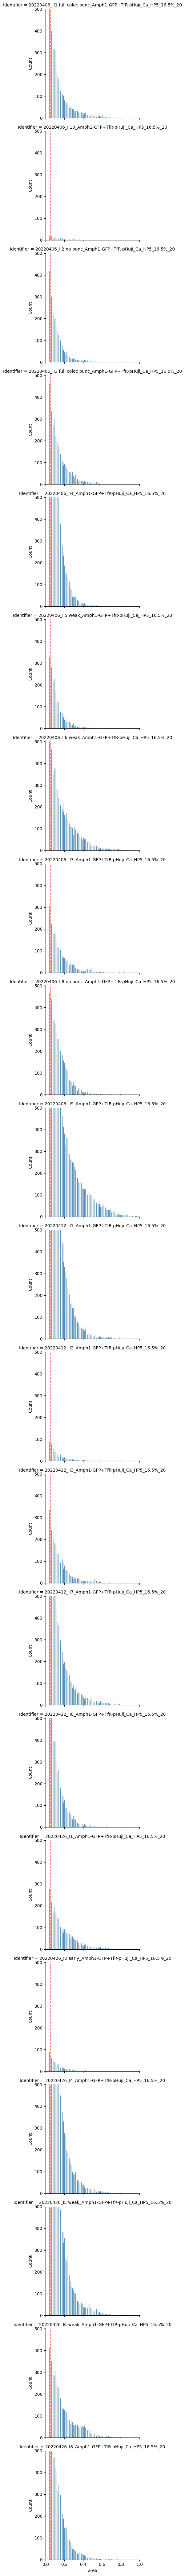

In [16]:
# Plot punctae sizes - Histogram
plt.figure(figsize=(12, 6))
g = sns.displot(df_lbl_props_C2, x="area", row="Identifier", height=4)
g.refline(x=filter_minsize_C2, color="red")
g.refline(x=filter_maxsize_C2, color="red")
g.set(xlim=(0,1))
g.set(ylim=(0, 500))

In [17]:
df_lbl_props_C1_backup = df_lbl_props_C1.copy()
df_lbl_props_C2_backup = df_lbl_props_C2.copy()

### Calculation of wound distance and circle number

In [18]:
df_lbl_props_C1["Distance"] = (np.sqrt((df_lbl_props_C1["centroid-1"]-df_lbl_props_C1["Wound_coord_X"])**2 + (df_lbl_props_C1["centroid-0"]-df_lbl_props_C1["Wound_coord_Y"])**2))
df_lbl_props_C2["Distance"] = (np.sqrt((df_lbl_props_C2["centroid-1"]-df_lbl_props_C2["Wound_coord_X"])**2 + (df_lbl_props_C2["centroid-0"]-df_lbl_props_C2["Wound_coord_Y"])**2))
df_lbl_props_C1["X_Norm"] = abs(df_lbl_props_C1["centroid-1"]-df_lbl_props_C1["Wound_coord_X"])
df_lbl_props_C1["Y_Norm"] = abs(df_lbl_props_C1["centroid-0"]-df_lbl_props_C1["Wound_coord_Y"])
df_lbl_props_C2["X_Norm"] = abs(df_lbl_props_C2["centroid-1"]-df_lbl_props_C2["Wound_coord_X"])
df_lbl_props_C2["Y_Norm"] = abs(df_lbl_props_C2["centroid-0"]-df_lbl_props_C2["Wound_coord_Y"])

In [19]:
# Circles
circle_bins = [0, 0.85, 10.85, 20.85, 30.85, 40.85, 50.85, 60.85, 70.85]#[0, 117, 234, 351, 468, 585, 702] # Check how big circles were in original paper
circles = list(range(0,len(circle_bins)-1))
df_lbl_props_C1["Circle"] = pd.cut(df_lbl_props_C1["Distance"], bins = circle_bins, include_lowest=True, labels=circles)
df_lbl_props_C2["Circle"] = pd.cut(df_lbl_props_C2["Distance"], bins = circle_bins, include_lowest=True, labels=circles)

In [20]:
df_lbl_props_C1.dropna(inplace=True)
df_lbl_props_C2.dropna(inplace=True)

In [21]:
df_lbl_props_C1 = pd.merge(df_lbl_props_C1, df_ROIs.loc[:, ["Area", "Identifier", "Circle"]], left_on= ["Identifier", "Circle"], right_on=["Identifier", "Circle"])
df_lbl_props_C2 = pd.merge(df_lbl_props_C2, df_ROIs.loc[:, ["Area", "Identifier", "Circle"]], left_on= ["Identifier", "Circle"], right_on=["Identifier", "Circle"])

In [22]:
#Filtering of punctae with size filter
df_lbl_props_C1 = df_lbl_props_C1[df_lbl_props_C1["area"] > filter_minsize_C1]
df_lbl_props_C1 = df_lbl_props_C1[df_lbl_props_C1["area"] < filter_maxsize_C1]
df_lbl_props_C2 = df_lbl_props_C2[df_lbl_props_C2["area"] > filter_minsize_C2]
df_lbl_props_C2 = df_lbl_props_C2[df_lbl_props_C2["area"] < filter_maxsize_C2]

In [23]:
#df_lbl_props_C2.to_csv(filepath+"\\"+"C2_punctaedata_filtered.csv")
#df_lbl_props_C1.to_csv(filepath+"\\"+"C1_punctaedata_filtered.csv")

In [24]:
if save_segmentation_filtered:
    print("Creating filtered label images.")


    lbl_imgs_filtered = []

    for i in tqdm(range(len(identifiers))):

        mask_array = np.full(lbl_imgs[i].shape, False)
        for frame in df_lbl_props_C1[(df_lbl_props_C1.Identifier == identifiers[i])].frame:
            list_to_keep = list(df_lbl_props_C1[((df_lbl_props_C1.Identifier == identifiers[i]) & (df_lbl_props_C1.frame == frame))].label)
            mask = np.isin(lbl_imgs[i][0, frame-1, :, :], list_to_keep)
            mask_array[0, frame-1, :, :] = mask

        for frame in df_lbl_props_C2[(df_lbl_props_C2.Identifier == identifiers[i])].frame:
            list_to_keep = list(df_lbl_props_C2[((df_lbl_props_C2.Identifier == identifiers[i]) & (df_lbl_props_C2.frame == frame))].label)
            mask = np.isin(lbl_imgs[i][1, frame-1, :, :], list_to_keep)
            mask_array[1, frame-1, :, :] = mask
    
        result_image = np.copy(lbl_imgs[i])
        result_image[~mask_array] = 0
        lbl_imgs_filtered.append(result_image)

In [25]:
if save_segmentation_filtered:
    print("Creating filtered label images.")

    #Save filtered images
    for number, lbl_image in tqdm(enumerate(lbl_imgs_filtered)):
        newpath = filepath + f"/{identifiers[number]}_Labels_filtered"
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        tiffname = newpath + f"/filtered_label.tiff"
        tfile.imwrite(tiffname, lbl_image[:, :, :, :])

<Axes: xlabel='Identifier', ylabel='count'>

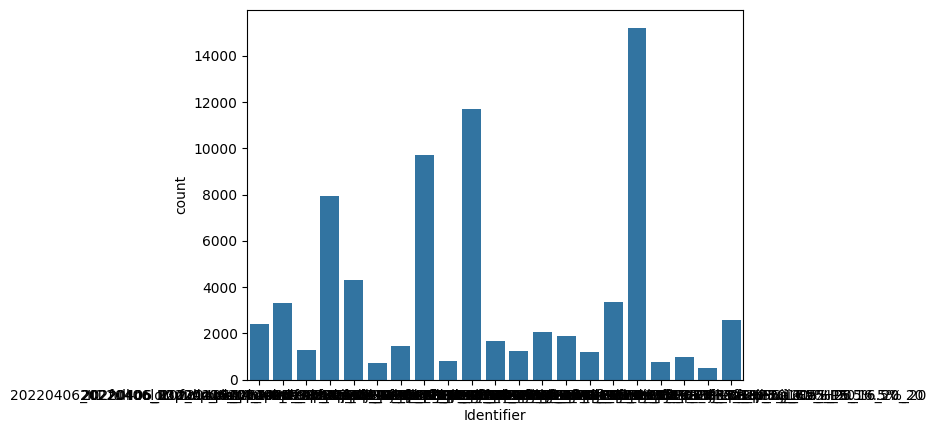

In [26]:
sns.countplot(data=df_lbl_props_C1, x="Identifier")

<Axes: xlabel='Identifier', ylabel='count'>

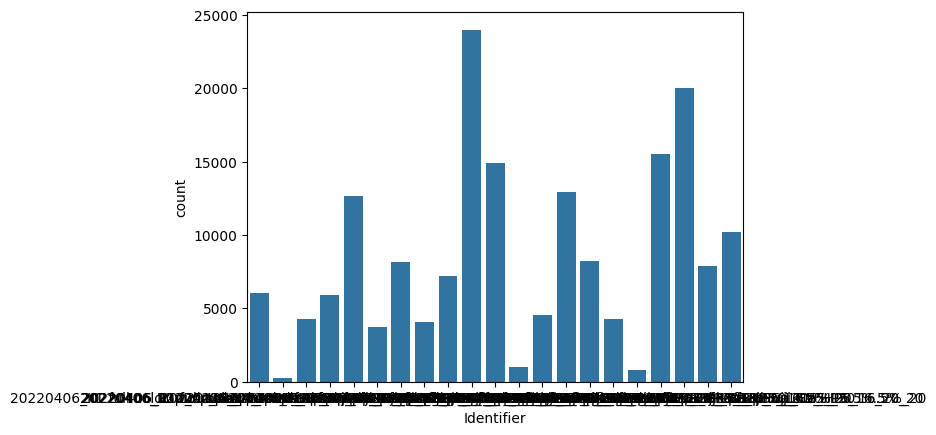

In [27]:
sns.countplot(data=df_lbl_props_C2, x="Identifier")

In [28]:
df_lbl_props_C1.groupby("Identifier").label.count()

Identifier
20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20     2423
20220406_II10_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                    3326
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20             1299
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20     7923
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     4326
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                 704
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                1432
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     9734
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20              801
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                    11723
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     1670
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     1237
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     2067
20220412_II7_Amph1-GFP+TfR-

In [29]:
df_lbl_props_C2.groupby("Identifier").label.count()

Identifier
20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20     6028
20220406_II10_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     229
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20             4274
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20     5896
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                    12677
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                3730
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                8142
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     4075
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20             7229
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                    23994
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                    14913
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                      971
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20                     4525
20220412_II7_Amph1-GFP+TfR-

In [30]:
# Backup of tables
df_C1 = df_lbl_props_C1.copy()
df_C2 = df_lbl_props_C2.copy()

In [31]:
df_pivot_C1 = df_C1.pivot_table(index=["Identifier", "Circle"], columns="frame", values="label", aggfunc='count', dropna=False)
df_pivot_C2 = df_C2.pivot_table(index=["Identifier", "Circle"], columns="frame", values="label", aggfunc='count', dropna=False)

In [32]:
df_pivot_C2.loc[:, 1].fillna(value=1, inplace=True, axis=0)
df_pivot_C1.loc[:, 1].fillna(value=1, inplace=True, axis=0)    
df_pivot_C2.fillna(value=0, inplace=True, axis=0)
df_pivot_C1.fillna(value=0, inplace=True, axis=0)

In [33]:
df_pivot_C1_area = df_C1.pivot_table(index=["Identifier", "Circle"], columns="frame", values="Area", aggfunc='mean', dropna=False)
df_pivot_C2_area = df_C2.pivot_table(index=["Identifier", "Circle"], columns="frame", values="Area", aggfunc='mean', dropna=False)

In [34]:
fill_value = 2.283
df_pivot_C1_area.loc[(slice(None), 0), :] = df_pivot_C1_area.loc[(slice(None), 0), :].fillna(fill_value)
df_pivot_C2_area.loc[(slice(None), 0), :] = df_pivot_C2_area.loc[(slice(None), 0), :].fillna(fill_value)

In [35]:
df_pivot_C1_area.fillna(method="bfill", inplace=True, axis=1)
df_pivot_C1_area.fillna(method="ffill", inplace=True, axis=1)
df_pivot_C2_area.fillna(method="bfill", inplace=True, axis=1)
df_pivot_C2_area.fillna(method="ffill", inplace=True, axis=1)

In [36]:
mean_frame_values_C2 = df_pivot_C2.groupby(level="Circle", axis=0).mean()
mean_frame_values_C1 = df_pivot_C1.groupby(level="Circle", axis=0).mean()

In [37]:
# Normalization to circle areas
df_pivot_C2_norm = df_pivot_C2/df_pivot_C2_area
df_pivot_C1_norm = df_pivot_C1/df_pivot_C1_area

# Normalilzation to first frame
df_pivot_C1_norm_2 = df_pivot_C1_norm.div(df_pivot_C1_norm.iloc[:, 0], axis=0)
df_pivot_C2_norm_2 = df_pivot_C2_norm.div(df_pivot_C2_norm.iloc[:, 0], axis=0)

In [38]:
mean_frame_values_C2_norm_2= df_pivot_C2_norm_2.groupby(level="Circle", axis=0).mean()
mean_frame_values_C1_norm_2 = df_pivot_C1_norm_2.groupby(level="Circle", axis=0).mean()
#median_frame_values_C2_norm_2= df_pivot_C2_norm_2.groupby(level="Circle", axis=0).median()
#median_frame_values_C1_norm_2 = df_pivot_C1_norm_2.groupby(level="Circle", axis=0).median()

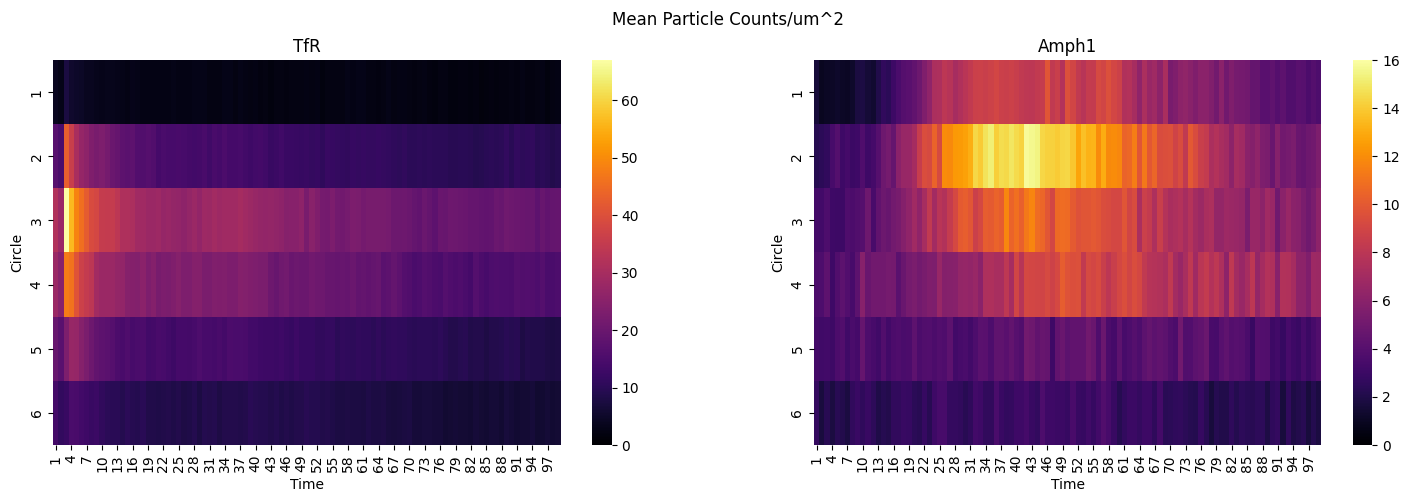

In [39]:
# Plotting
# We start at 0, if you want to plot frame 2 , use 1
min_frame = 0
max_frame = 99
colormap = "inferno" # Other options: "viridis", "inferno", "plasma", "magma", "cividis"
xlabel = "Time"
ylabel = "Circle"
legendlabel = "Normalized events of TfR and Amph1 after wounding"
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

# cbar=False
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5), gridspec_kw={'width_ratios': [1, 1]} ) #sharey=True,
sns.heatmap(mean_frame_values_C2.iloc[1:, min_frame:max_frame], vmin=0, vmax=math.ceil(mean_frame_values_C2.max().max()), cmap=colormap, ax=axes[0]).set_title("TfR")
sns.heatmap(mean_frame_values_C1.iloc[1:, min_frame:max_frame], vmin=0, vmax=math.ceil(mean_frame_values_C1.max().max()), cmap=colormap, ax=axes[1]).set_title("Amph1")
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[1].set_xlabel(xlabel)
axes[1].set_ylabel(ylabel)
fig.suptitle("Mean Particle Counts/um^2")
# Saving figure
plt.savefig(filepath+"\\"+"ParcticleCounts.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

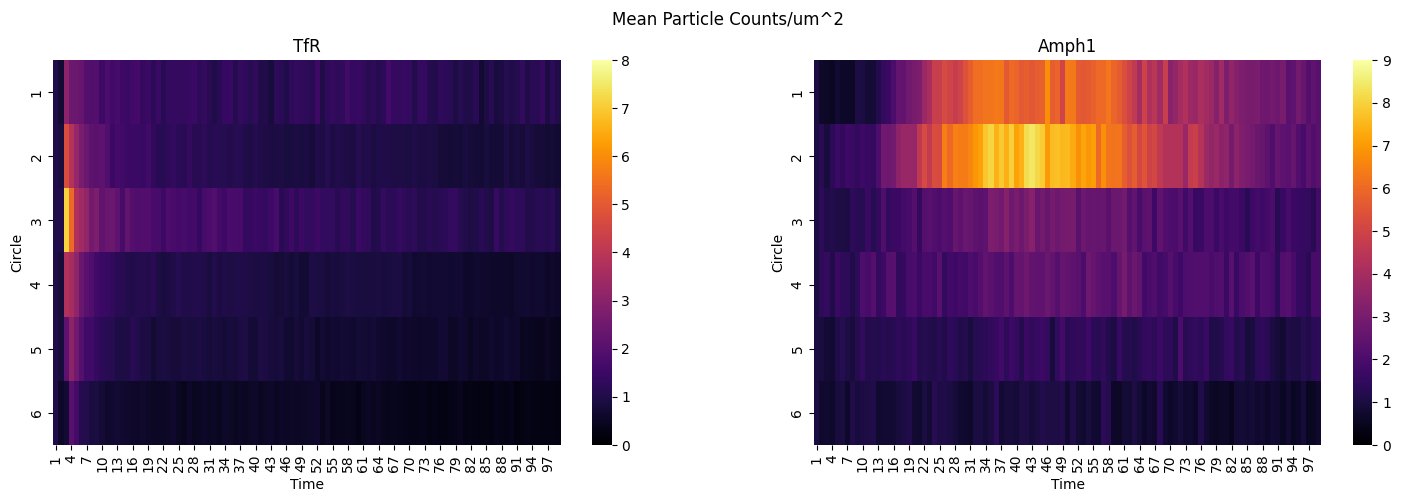

In [40]:
# Plotting
# We start at 0, if you want to plot frame 2 , use 1
min_frame = 0
max_frame = 99
colormap = "inferno" # Other options: "viridis", "inferno", "plasma", "magma", "cividis"
xlabel = "Time"
ylabel = "Circle"
legendlabel = "Normalized events of TfR and Amph1 after wounding"
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

# cbar=False
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5), gridspec_kw={'width_ratios': [1, 1]} ) #sharey=True,
sns.heatmap(mean_frame_values_C2_norm_2.iloc[1:, min_frame:max_frame], vmin=0, vmax=math.ceil(mean_frame_values_C2_norm_2.max().max()), cmap=colormap, ax=axes[0]).set_title("TfR")
sns.heatmap(mean_frame_values_C1_norm_2.iloc[1:, min_frame:max_frame], vmin=0, vmax=math.ceil(mean_frame_values_C1_norm_2.max().max()), cmap=colormap, ax=axes[1]).set_title("Amph1")
axes[0].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[1].set_xlabel(xlabel)
axes[1].set_ylabel(ylabel)
fig.suptitle("Mean Particle Counts/um^2")

# Saving figure
plt.savefig(filepath+"\\"+"ParcticleCounts_norm.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

In [42]:
"""unique_identifiers = df_C2.Identifier.unique()
for identifier in unique_identifiers:
    subset_pivot_C1 = df_pivot_C1_norm_2.xs(key=identifier)
    subset_pivot_C2 = df_pivot_C2_norm_2.xs(key=identifier)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5), gridspec_kw={'width_ratios': [1, 1]} ) #sharey=True,
    sns.heatmap(subset_pivot_C2.iloc[:, min_frame:max_frame], vmin=0, cmap=colormap, ax=axes[0]).set_title("TfR")
    sns.heatmap(subset_pivot_C1.iloc[:, min_frame:max_frame], vmin=0, cmap=colormap, ax=axes[1]).set_title("Amph1")
    fig.suptitle(f"Heatmap for {identifier}")
    plt.savefig(f"{filepath}\\Heatmap_{identifier}.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")"""

'unique_identifiers = df_C2.Identifier.unique()\nfor identifier in unique_identifiers:\n    subset_pivot_C1 = df_pivot_C1_norm_2.xs(key=identifier)\n    subset_pivot_C2 = df_pivot_C2_norm_2.xs(key=identifier)\n    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5), gridspec_kw={\'width_ratios\': [1, 1]} ) #sharey=True,\n    sns.heatmap(subset_pivot_C2.iloc[:, min_frame:max_frame], vmin=0, cmap=colormap, ax=axes[0]).set_title("TfR")\n    sns.heatmap(subset_pivot_C1.iloc[:, min_frame:max_frame], vmin=0, cmap=colormap, ax=axes[1]).set_title("Amph1")\n    fig.suptitle(f"Heatmap for {identifier}")\n    plt.savefig(f"{filepath}\\Heatmap_{identifier}.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")'

## Density Plots

Those density plots are basically histograms that plot the distribution of the punctae. The difference is:
A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations. Kernel density estimation (KDE) presents a different solution to the same problem. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. 



In [43]:
# Timepoint of maximum count:
print(f"Amph-1: {df_C1.groupby('frame').count().label.idxmax()}")
print(f"TfR: {df_C2.groupby('frame').count().label.idxmax()}")

Amph-1: 42
TfR: 3


### Density plot - Normalized distance to wound
Here, the density of the punctae based on the normalized distance to the wound (basically wound coordinates are set to (0,0)) are plotted

In [44]:
"""circle1 = plt.Circle((0, 0), 11, color='w', fill=False, clip_on=True)
circle2 = plt.Circle((0, 0), 21, color='w', fill=False, clip_on=True)
circle3 = plt.Circle((0, 0), 31, color='w', fill=False, clip_on=True)
circle4 = plt.Circle((0, 0), 41, color='w', fill=False, clip_on=True)
circle5 = plt.Circle((0, 0), 51, color='w', fill=False, clip_on=True)
circle6 = plt.Circle((0, 0), 61, color='w', fill=False, clip_on=True)
circle11 = plt.Circle((0, 0), 11, color='w', fill=False, clip_on=True)
circle22 = plt.Circle((0, 0), 21, color='w', fill=False, clip_on=True)
circle33 = plt.Circle((0, 0), 31, color='w', fill=False, clip_on=True)
circle44 = plt.Circle((0, 0), 41, color='w', fill=False, clip_on=True)
circle55 = plt.Circle((0, 0), 51, color='w', fill=False, clip_on=True)
circle66 = plt.Circle((0, 0), 61, color='w', fill=False, clip_on=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
sns.kdeplot(x=df_C2.X_Norm, y=df_C2.Y_Norm, fill=True, cmap="inferno", ax=axes[0]).set_title("TfR")
sns.kdeplot(x=df_C1.X_Norm, y=df_C1.Y_Norm, fill=True, cmap="inferno", ax=axes[1]).set_title("Amph-1")
axes[0].set_facecolor((0,0,0))
axes[0].add_patch(circle1)
axes[0].add_patch(circle2)
axes[0].add_patch(circle3)
axes[0].add_patch(circle4)
axes[0].add_patch(circle5)
axes[0].add_patch(circle6)
axes[1].set_facecolor((0,0,0))
axes[1].add_patch(circle11)
axes[1].add_patch(circle22)
axes[1].add_patch(circle33)
axes[1].add_patch(circle44)
axes[1].add_patch(circle55)
axes[1].add_patch(circle66)
axes[0].set_xlim(0,60)
axes[0].set_ylim(0,60)
axes[1].set_xlim(0,60)
axes[1].set_ylim(0,60)

# Saving figure
plt.savefig(filepath+"\\"+"DensityPlots_XY.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")"""

'circle1 = plt.Circle((0, 0), 11, color=\'w\', fill=False, clip_on=True)\ncircle2 = plt.Circle((0, 0), 21, color=\'w\', fill=False, clip_on=True)\ncircle3 = plt.Circle((0, 0), 31, color=\'w\', fill=False, clip_on=True)\ncircle4 = plt.Circle((0, 0), 41, color=\'w\', fill=False, clip_on=True)\ncircle5 = plt.Circle((0, 0), 51, color=\'w\', fill=False, clip_on=True)\ncircle6 = plt.Circle((0, 0), 61, color=\'w\', fill=False, clip_on=True)\ncircle11 = plt.Circle((0, 0), 11, color=\'w\', fill=False, clip_on=True)\ncircle22 = plt.Circle((0, 0), 21, color=\'w\', fill=False, clip_on=True)\ncircle33 = plt.Circle((0, 0), 31, color=\'w\', fill=False, clip_on=True)\ncircle44 = plt.Circle((0, 0), 41, color=\'w\', fill=False, clip_on=True)\ncircle55 = plt.Circle((0, 0), 51, color=\'w\', fill=False, clip_on=True)\ncircle66 = plt.Circle((0, 0), 61, color=\'w\', fill=False, clip_on=True)\n\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))\nsns.kdeplot(x=df_C2.X_Norm, y=df_C2.Y_Norm, fill=True, 

In [45]:
"""unique_identifiers = df_C2.Identifier.unique()
for identifier in unique_identifiers:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))    
    sns.kdeplot(x=df_C2[df_C2.Identifier == identifier].X_Norm, y=df_C2[df_C2.Identifier == identifier].Y_Norm, fill=True, cmap="inferno", ax=axes[0]).set_title("TfR")
    sns.kdeplot(x=df_C1[df_C1.Identifier == identifier].X_Norm, y=df_C1[df_C1.Identifier == identifier].Y_Norm, fill=True, cmap="inferno", ax=axes[1]).set_title("Amph-1")"""

'unique_identifiers = df_C2.Identifier.unique()\nfor identifier in unique_identifiers:\n    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))    \n    sns.kdeplot(x=df_C2[df_C2.Identifier == identifier].X_Norm, y=df_C2[df_C2.Identifier == identifier].Y_Norm, fill=True, cmap="inferno", ax=axes[0]).set_title("TfR")\n    sns.kdeplot(x=df_C1[df_C1.Identifier == identifier].X_Norm, y=df_C1[df_C1.Identifier == identifier].Y_Norm, fill=True, cmap="inferno", ax=axes[1]).set_title("Amph-1")'

# Nearest Neighbor distance

We calculate the distance for all particles in circle 1  (first circle after the small wound circle) in the TfR channel to the distances of the Amph particles for each individual frame.

If the Amph1 particles accumulate at the wound, the distance will become shorter over time.

In [46]:
# Clean up the tables
df_C1.dropna(inplace=True) 
df_C1.reset_index(inplace=True)
df_C2.dropna(inplace=True)
df_C2.reset_index(inplace=True)
print(df_C1["Circle"].unique())
print(df_C2["Circle"].unique())

[4 3 6 2 1 5 0]
[4 5 6 3 2 1 0]


In [47]:
def find_NN(df_C2_filtered, df_C1):
    nn = pd.DataFrame()
    nn_df = pd.DataFrame()
    list_alldistances= []
    gb_C2 = df_C2_filtered.groupby("Identifier")
    gb_C1 = df_C1.groupby("Identifier")

    nn_list = []
    for group in df_C2_filtered["Identifier"].unique():
        print(group)
        list_nn = []
        dict_dist, dict_indi = {}, {}
        group_C1 = gb_C1.get_group(group)
        group_C2 = gb_C2.get_group(group)    
        #print(f"C1:{group_C1.shape}")
        #print(f"C2:{group_C2.shape}")
    
        for frame in range(group_C1.frame.max()):
            nn = pd.DataFrame()    
            try:
                tree = KDTree(group_C1[group_C1.frame == frame+1].iloc[:, 6:8])
                distances, indices = tree.query(group_C2.iloc[:, 6:8], 1)
                nn = group_C1[(group_C1.frame == frame+1)].iloc[list(indices.flatten())]
                nn["Particle_C2"] = list(group_C2.label)
                nn["Particle_C2_X"] = list(group_C2["centroid-1"])
                nn["Particle_C2_Y"] = list(group_C2["centroid-0"])
                nn["Distance_NN"] = list(distances.flatten())
                nn_list.append(nn)
            except:
                print(f"No particles in Frame {frame}")
    nn_df = pd.concat(nn_list)
    
    return nn_df

# Circle 1

In [48]:
# Filtering:
# TfR 3 - 10
df_C2_filtered = df_C2[(df_C2.frame > 2) & (df_C2.frame < 11)]
df_C2_filtered_Circle1 = df_C2_filtered[(df_C2_filtered.Circle < 2)]

In [49]:
nn_df_circle1 = find_NN(df_C2_filtered_Circle1, df_C1)
nn_df_circle1.to_csv(filepath+"\\"+"Circle1_NN.csv")

20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
No particles in Frame 76
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II8_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I2 early_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
No particles in Frame 9

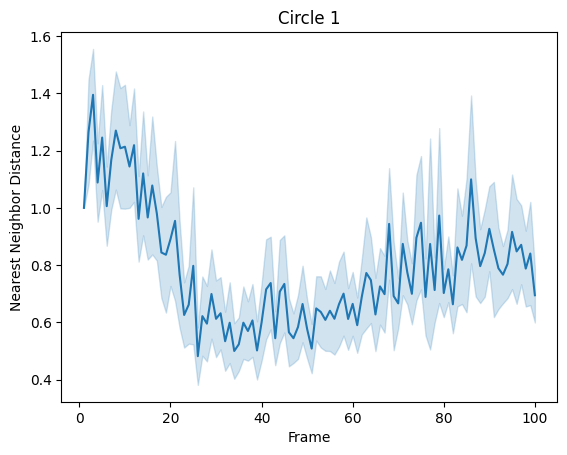

In [50]:
pivot_nn = pd.pivot_table(data=nn_df_circle1, index="frame", columns="Identifier", values="Distance_NN", aggfunc='mean', dropna=False)
pivot_nn_norm_circle1 = pivot_nn/pivot_nn.iloc[0, :]
pivot_nn_norm_circle1["frame"] = pivot_nn_norm_circle1.index
pivot_nn_norm.to_csv(filepath+"\\"+"Circle1_Normalized_NN.csv")
nn_norm_circle1 = pd.melt(pivot_nn_norm_circle1, id_vars="frame" )

# Plot NN Distance
sns.lineplot(data=nn_norm_circle1, x="frame", y="value", estimator="mean", err_style="band", errorbar=("se"))
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")
plt.title("Circle 1")

plt.savefig(filepath+"\\"+"NN_LinePlot_Circle1.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

# Circle 1 and 2

In [51]:
# Filtering:
# TfR 3 - 10
df_C2_filtered = df_C2[(df_C2.frame > 2) & (df_C2.frame < 11)]
df_C2_filtered_Circle12 = df_C2_filtered[(df_C2_filtered.Circle < 3)]
nn_df_circle12 = find_NN(df_C2_filtered_Circle12, df_C1)
nn_df_circle12.to_csv(filepath+"\\"+"Circle12_NN.csv")

20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II10_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
No particles in Frame 76
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II8_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I2 early_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I5 weak_Amph1-GFP+TfR-

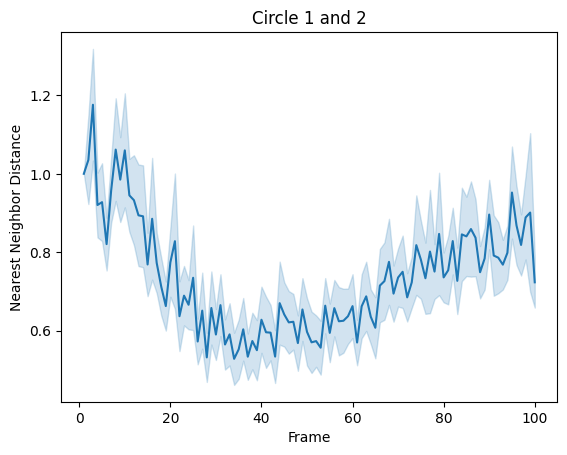

In [52]:
pivot_nn = pd.pivot_table(data=nn_df_circle12, index="frame", columns="Identifier", values="Distance_NN", aggfunc='mean', dropna=False)
pivot_nn_norm_circle = pivot_nn/pivot_nn.iloc[0, :]
pivot_nn_norm_circle["frame"] = pivot_nn_norm_circle.index
pivot_nn_norm.to_csv(filepath+"\\"+"Circle12_Normalized_NN.csv")
nn_norm_circle12 = pd.melt(pivot_nn_norm_circle, id_vars="frame" )

#Plot NN Distance
sns.lineplot(data=nn_norm_circle12, x="frame", y="value", estimator="mean", err_style="band", errorbar=("se"))
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")
plt.title("Circle 1 and 2")

plt.savefig(filepath+"\\"+"NN_LinePlot_Circle12.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

# Circle 2

In [53]:
# Filtering:
# TfR 3 - 10
df_C2_filtered = df_C2[(df_C2.frame > 2) & (df_C2.frame < 11)]
df_C2_filtered_Circle2 = df_C2_filtered[(df_C2_filtered.Circle > 1) & (df_C2_filtered.Circle < 3)]

In [54]:
nn_df_circle2 = find_NN(df_C2_filtered_Circle2, df_C1)
nn_df_circle2.to_csv(filepath+"\\"+"Circle2_NN.csv")

20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II10_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
No particles in Frame 76
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II8_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I2 early_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I5 weak_Amph1-GFP+TfR-

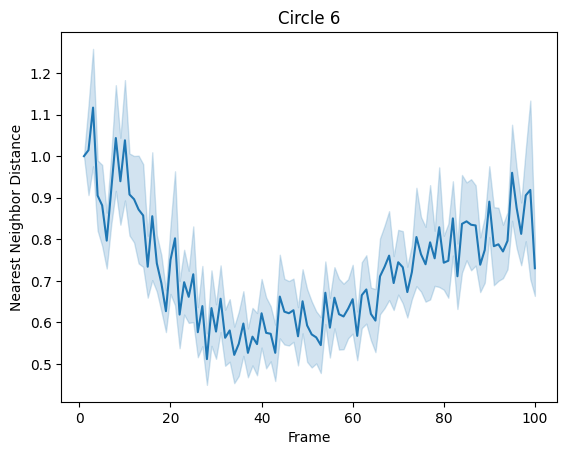

In [55]:
pivot_nn = pd.pivot_table(data=nn_df_circle2, index="frame", columns="Identifier", values="Distance_NN", aggfunc='mean', dropna=False)
pivot_nn_norm = pivot_nn/pivot_nn.iloc[0, :]
pivot_nn_norm["frame"] = pivot_nn_norm.index
pivot_nn_norm.to_csv(filepath+"\\"+"Circle2_Normalized_NN.csv")
nn_norm_circle2 = pd.melt(pivot_nn_norm, id_vars="frame")

sns.lineplot(data=nn_norm_circle2, x="frame", y="value", estimator="mean", err_style="band", errorbar=("se"))
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")
plt.title("Circle 6")

plt.savefig(filepath+"\\"+"NN_LinePlot_Circle2.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

# Circle 6

In [56]:
# Filtering:
# TfR 3 - 10
df_C2_filtered = df_C2[(df_C2.frame > 2) & (df_C2.frame < 11)]
df_C2_filtered_Circle6 = df_C2_filtered[(df_C2_filtered.Circle > 4) & (df_C2_filtered.Circle < 6)]

In [57]:
nn_df_circle6 = find_NN(df_C2_filtered_Circle6, df_C1)
nn_df_circle6.to_csv(filepath+"\\"+"Circle6_NN.csv")

20220406_II1 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II10_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II2 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II3 full coloc punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II5 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
No particles in Frame 76
20220406_II6 weak_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II8 no punc_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220406_II9_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II2_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II3_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II7_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220412_II8_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I1_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I2 early_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I4_Amph1-GFP+TfR-pHuji_Ca_HP5_16.5%_20
20220426_I5 weak_Amph1-GFP+TfR-

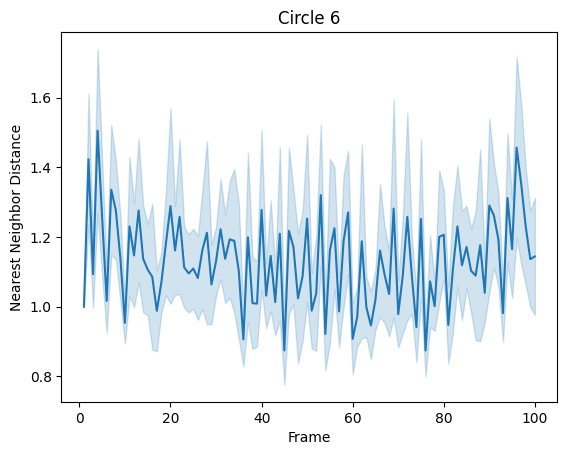

In [58]:
pivot_nn = pd.pivot_table(data=nn_df_circle6, index="frame", columns="Identifier", values="Distance_NN", aggfunc='mean', dropna=False)
pivot_nn_norm = pivot_nn/pivot_nn.iloc[0, :]
pivot_nn_norm["frame"] = pivot_nn_norm.index
pivot_nn_norm.to_csv(filepath+"\\"+"Circle6_Normalized_NN.csv")
nn_norm_circle6 = pd.melt(pivot_nn_norm, id_vars="frame")

sns.lineplot(data=nn_norm_circle6, x="frame", y="value", estimator="mean", err_style="band", errorbar=("se"))
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")
plt.title("Circle 6")

plt.savefig(filepath+"\\"+"NN_LinePlot_Circle6.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

### Overlay NN Distances for different circles

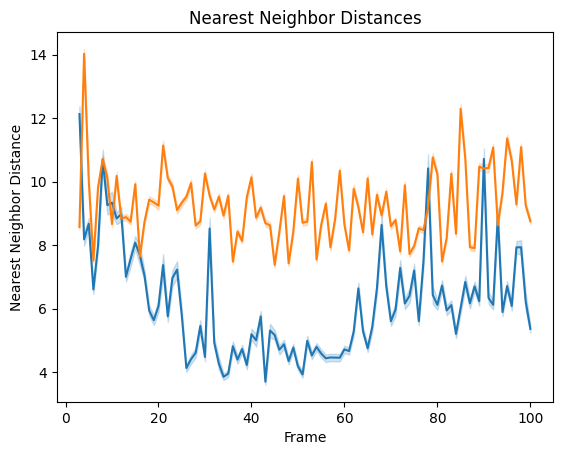

In [59]:
sns.lineplot(data=nn_df_circle1[nn_df_circle1.frame > 2], x="frame", y="Distance_NN", estimator="mean", err_style="band", errorbar=("se"))
#sns.lineplot(data=nn_df_circle6[nn_df_circle12.frame > 2], x="frame", y="Distance_NN", estimator="mean", err_style="band", errorbar=("se"))
sns.lineplot(data=nn_df_circle6[nn_df_circle6.frame > 2], x="frame", y="Distance_NN", estimator="mean", err_style="band", errorbar=("se"))
plt.title("Nearest Neighbor Distances")
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")

plt.savefig(filepath+"\\"+"NN_LinePlots_Circles.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

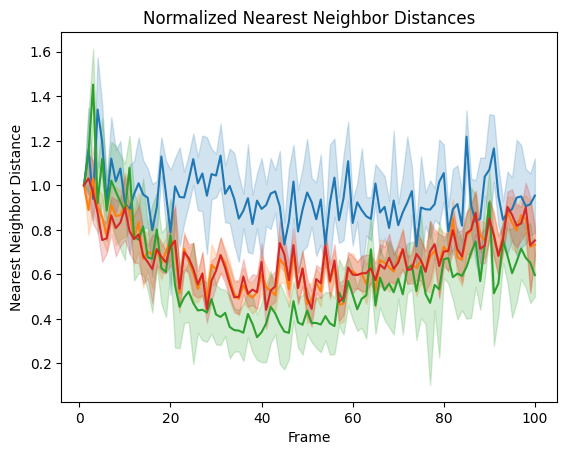

In [74]:
sns.lineplot(data=nn_norm_circle6, x="frame", y="value", estimator="median", err_style="band", errorbar=("se"))
sns.lineplot(data=nn_norm_circle12, x="frame", y="value", estimator="median", err_style="band", errorbar=("se"))
sns.lineplot(data=nn_norm_circle1, x="frame", y="value", estimator="median", err_style="band", errorbar=("se"))
sns.lineplot(data=nn_norm_circle2, x="frame", y="value", estimator="median", err_style="band", errorbar=("se"))

plt.title("Normalized Nearest Neighbor Distances")
plt.ylabel("Nearest Neighbor Distance")
plt.xlabel("Frame")

plt.savefig(filepath+"\\"+"NN_NormalizedLinePlots_Circles.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

### Graphical representation

### Circle 1

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:23<00:00,  3.99s/it]


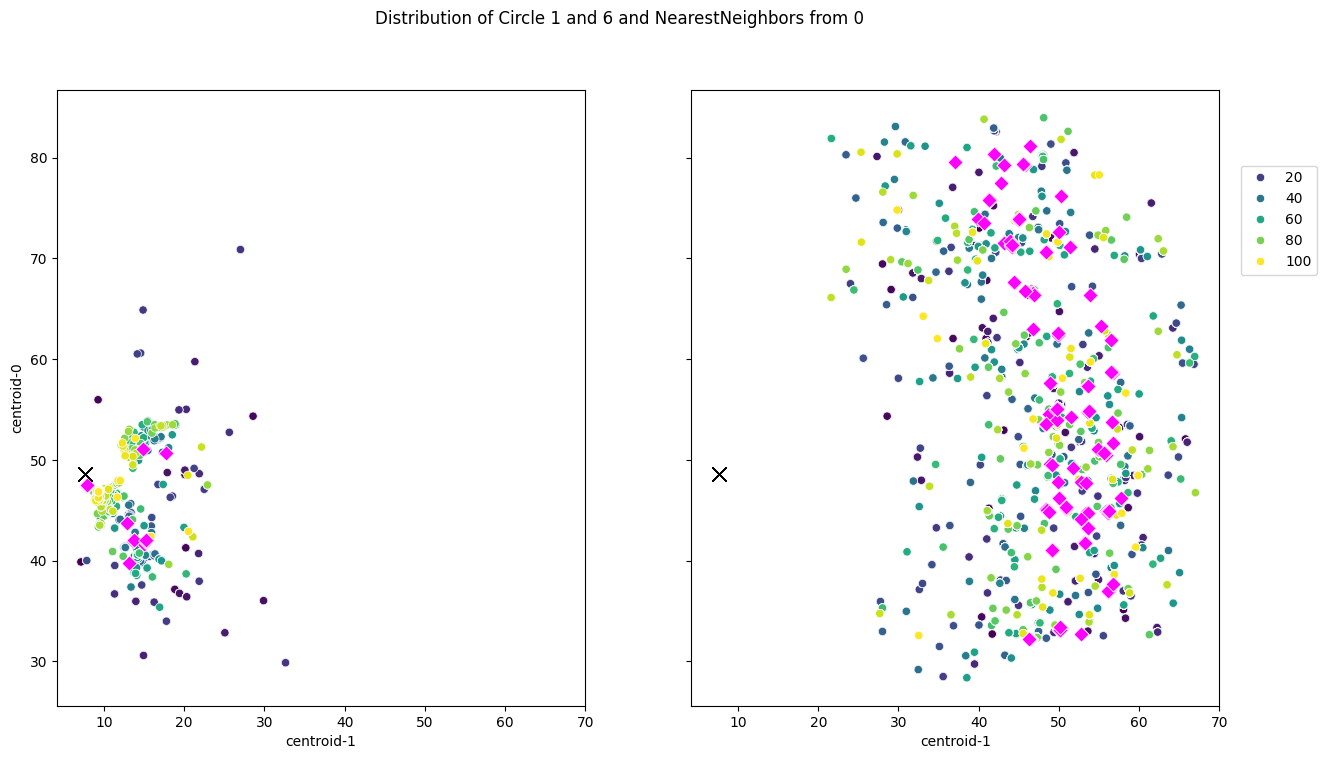

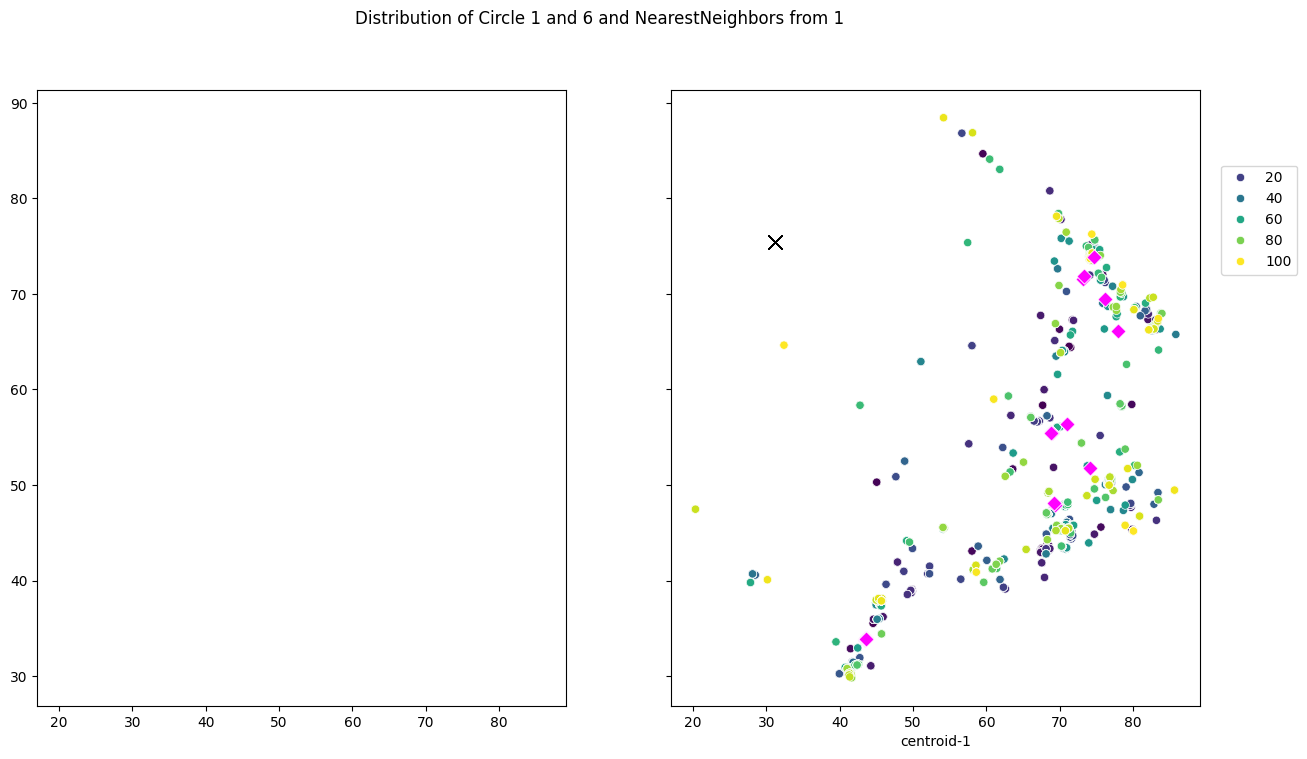

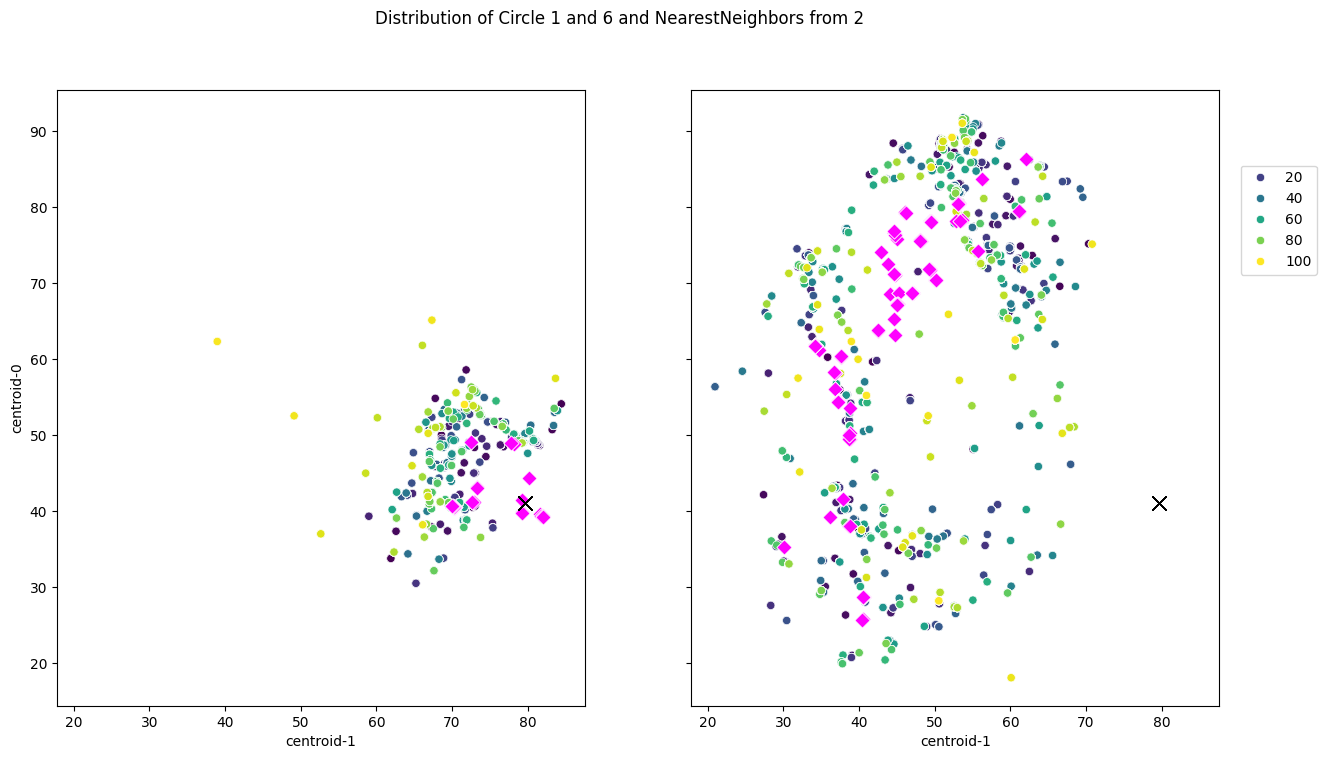

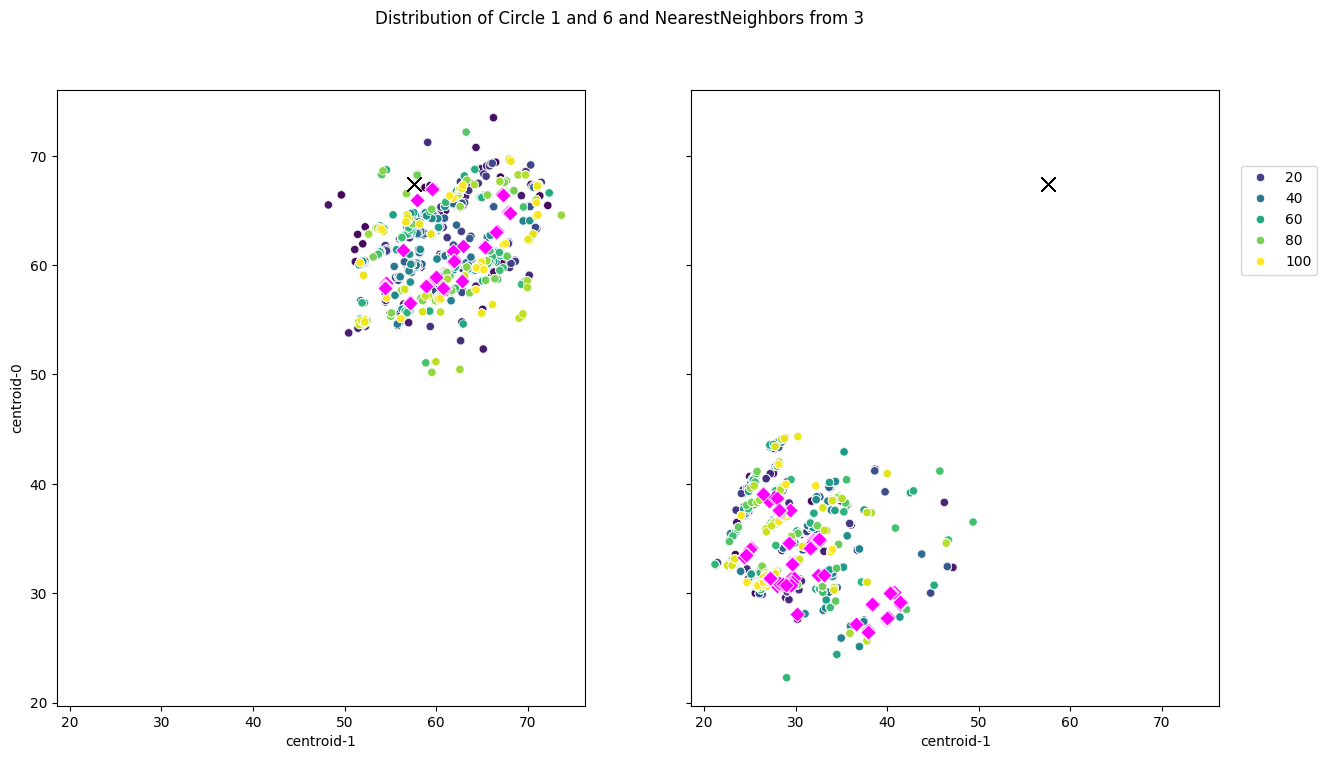

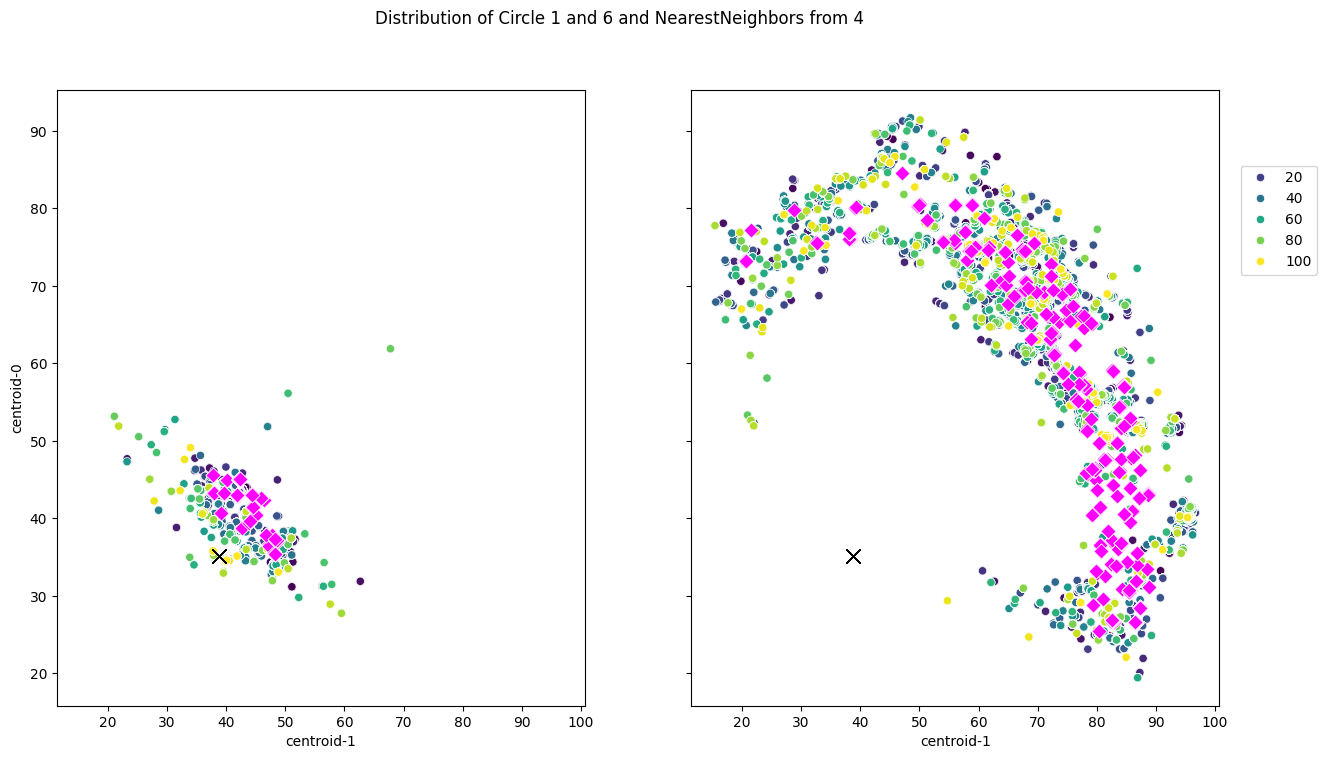

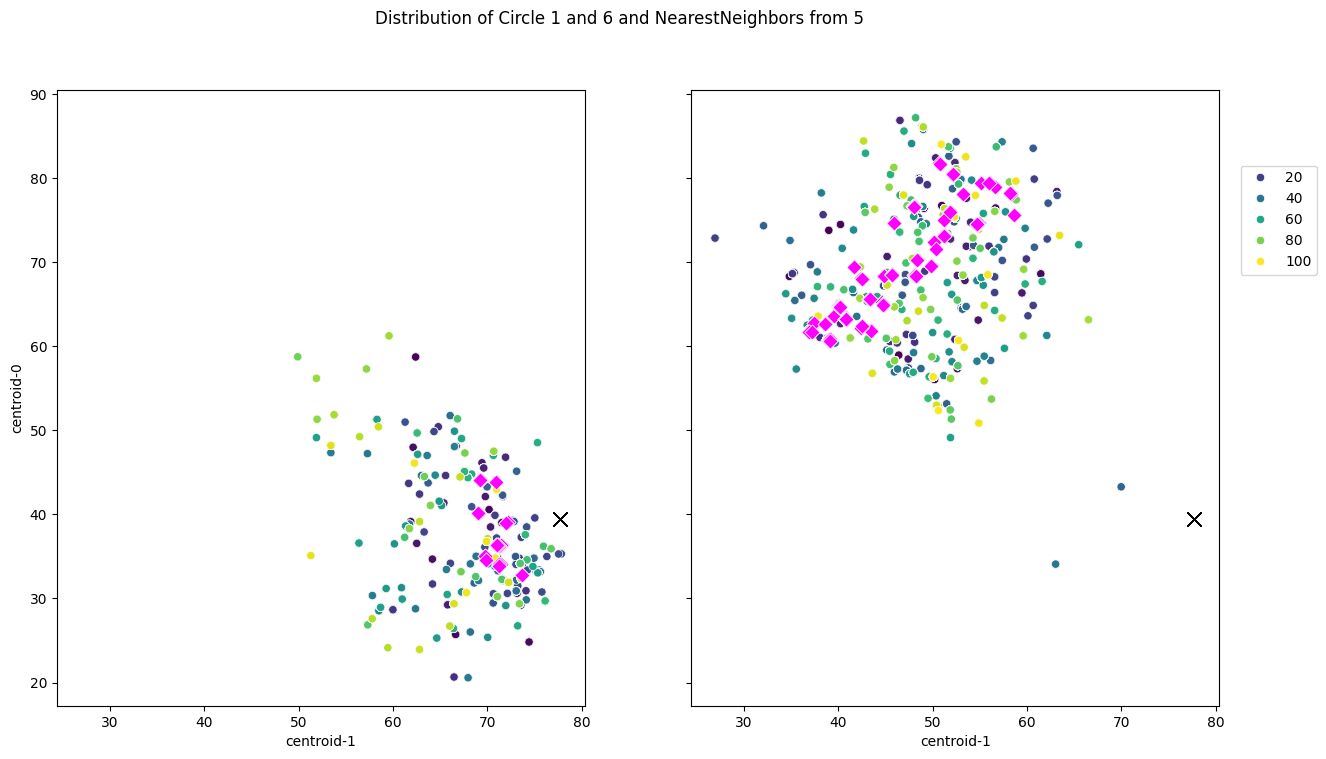

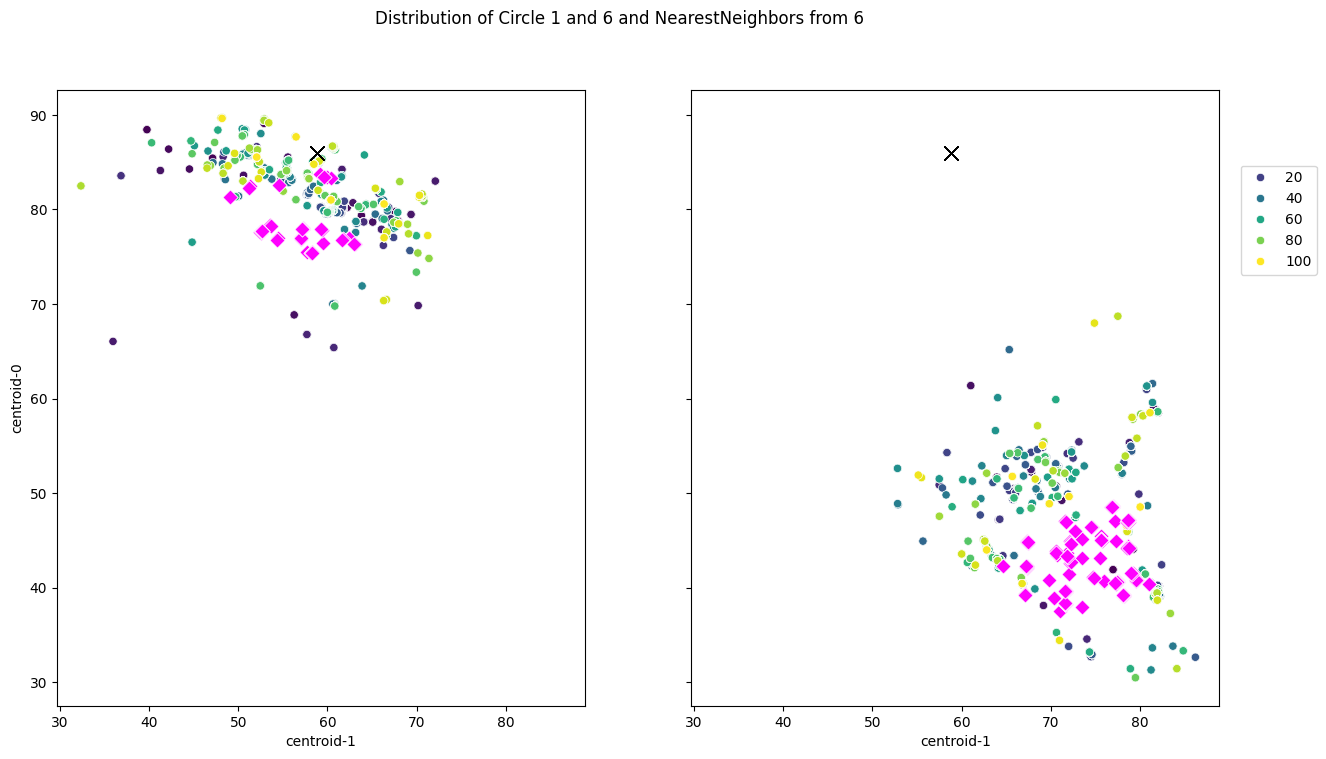

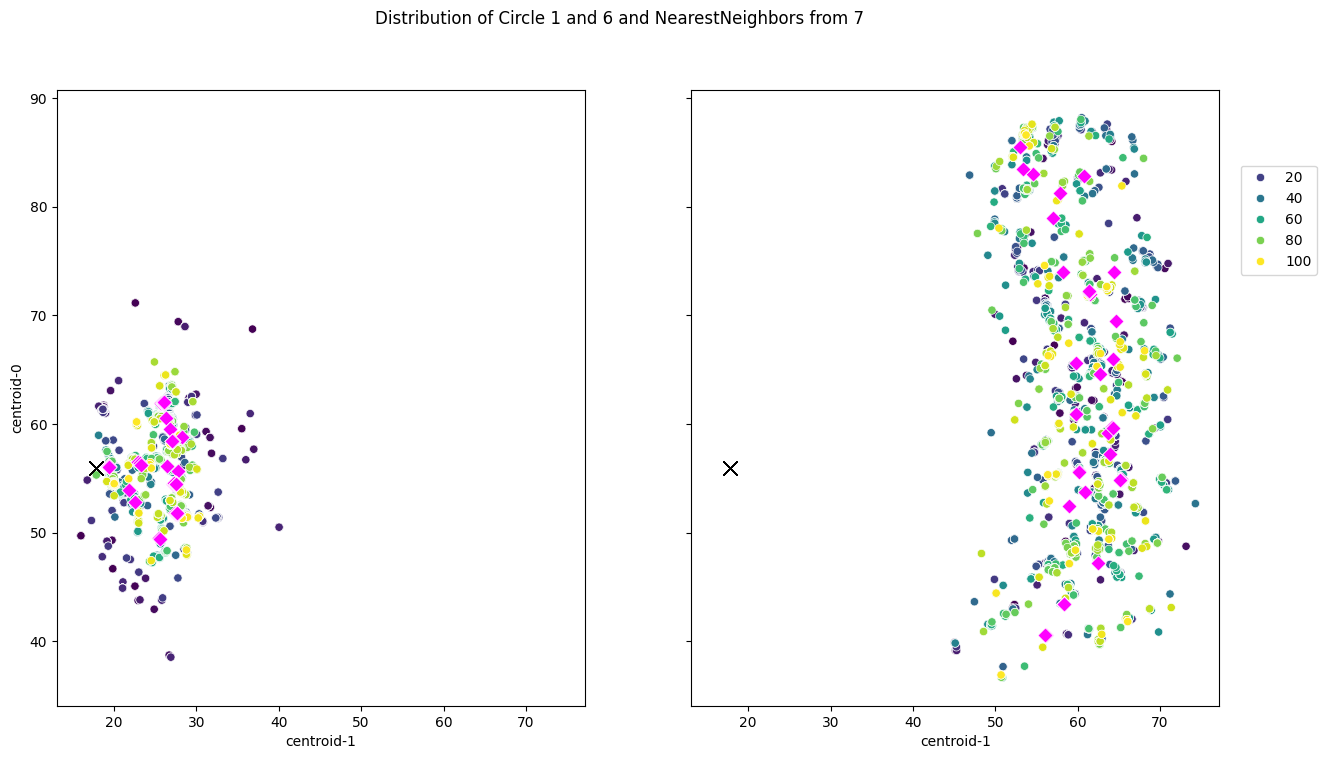

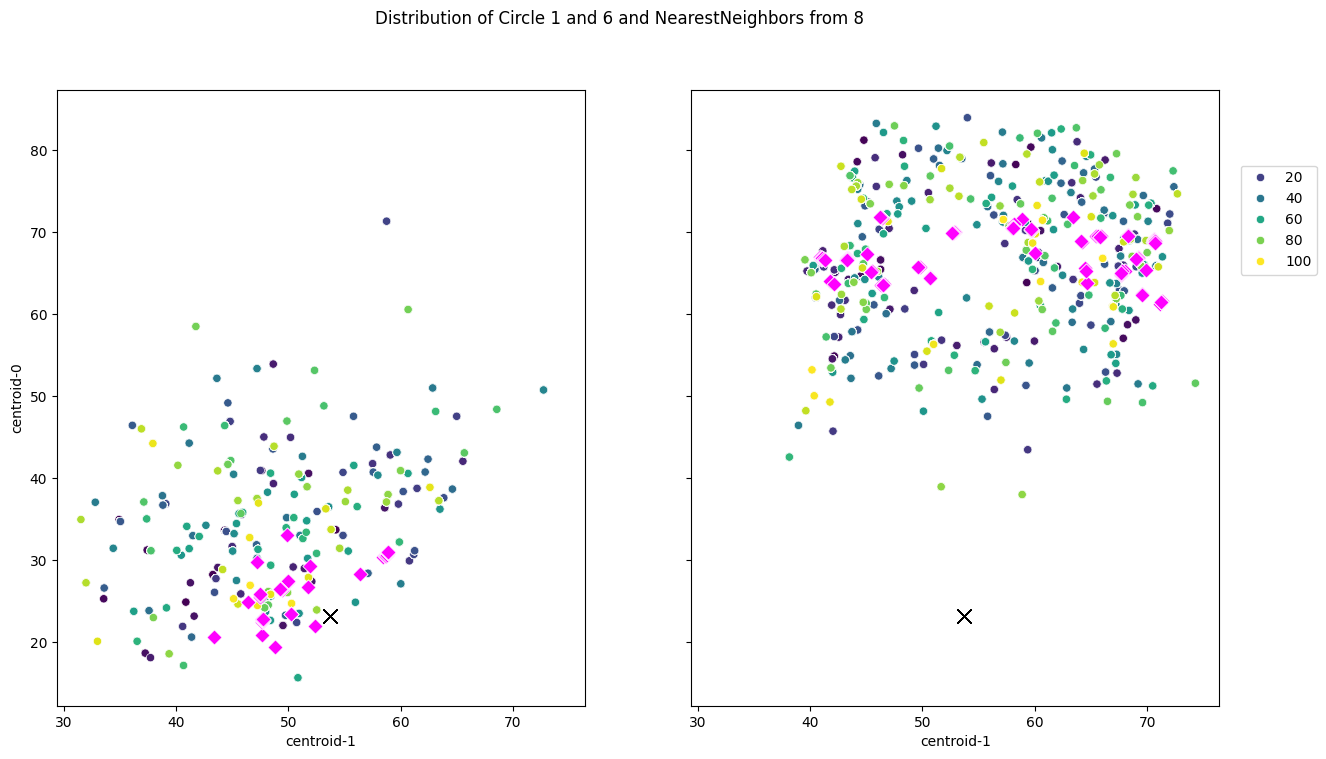

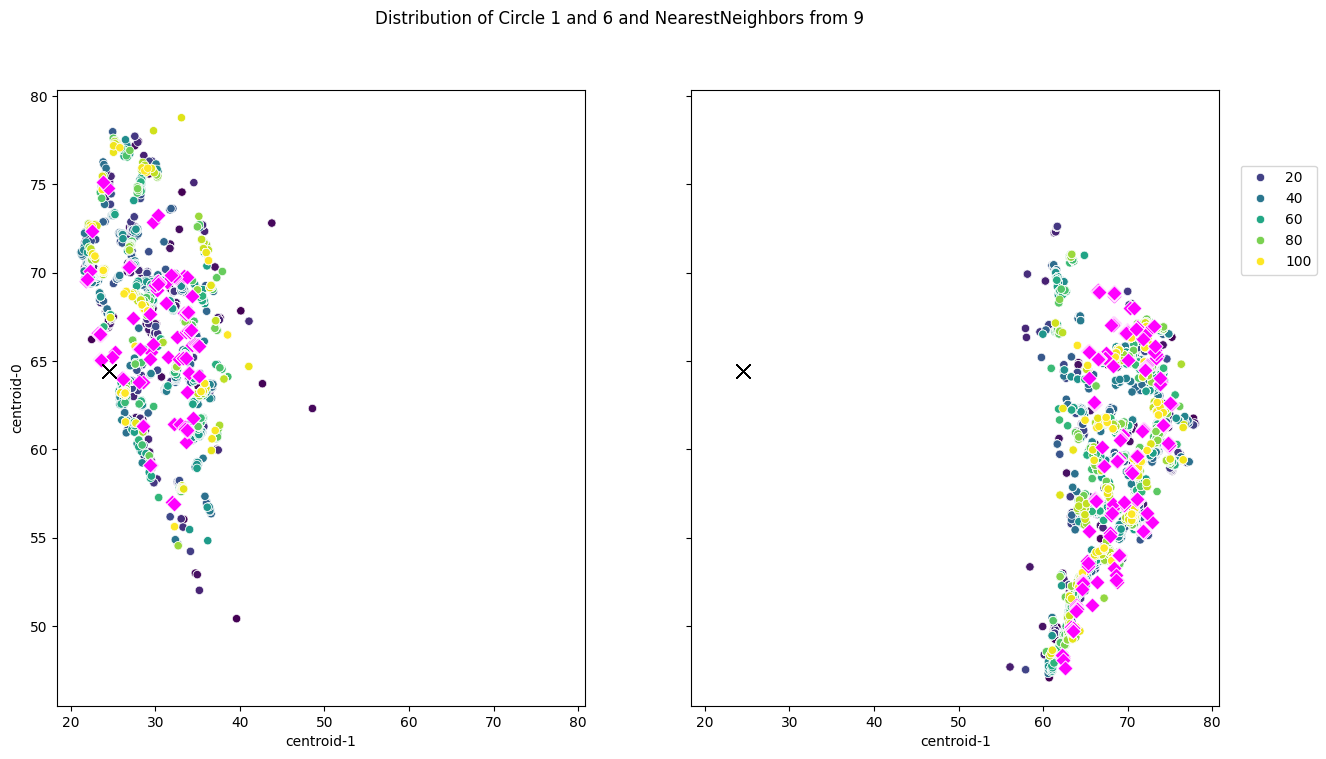

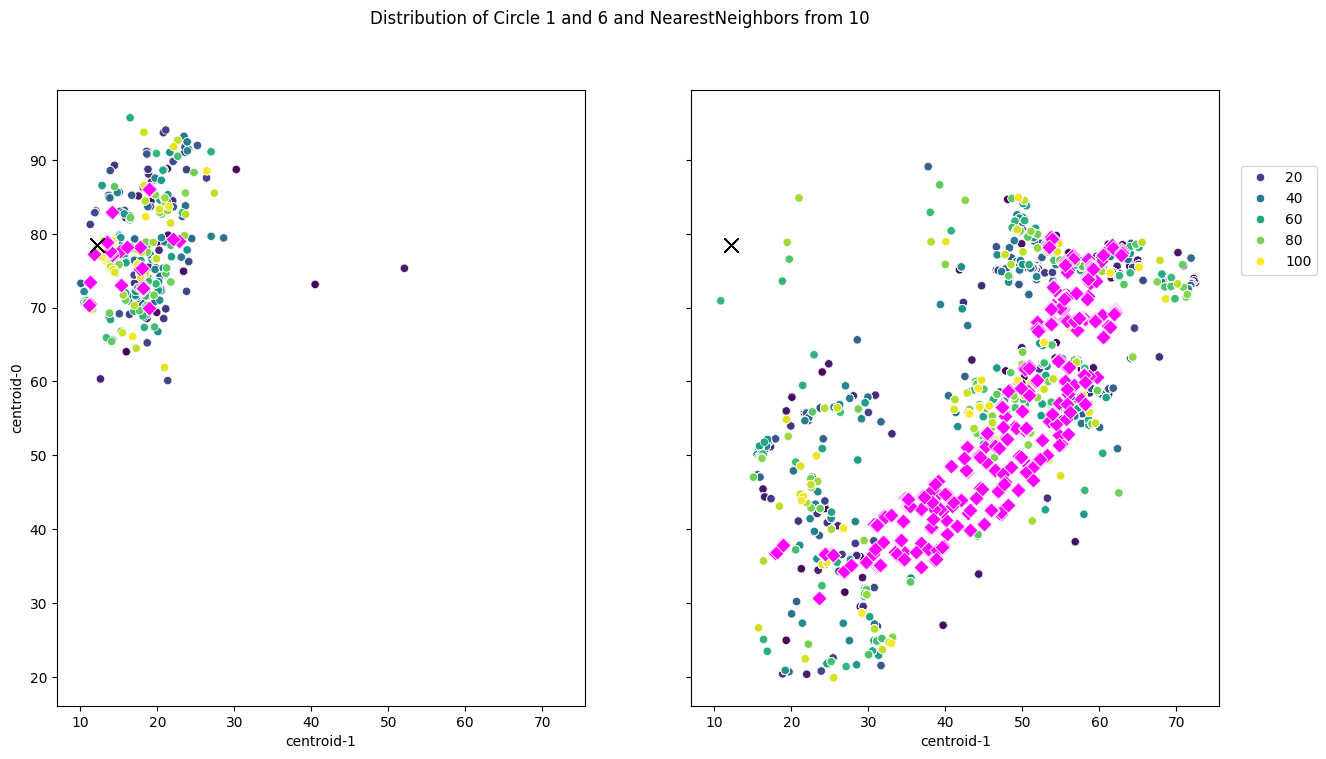

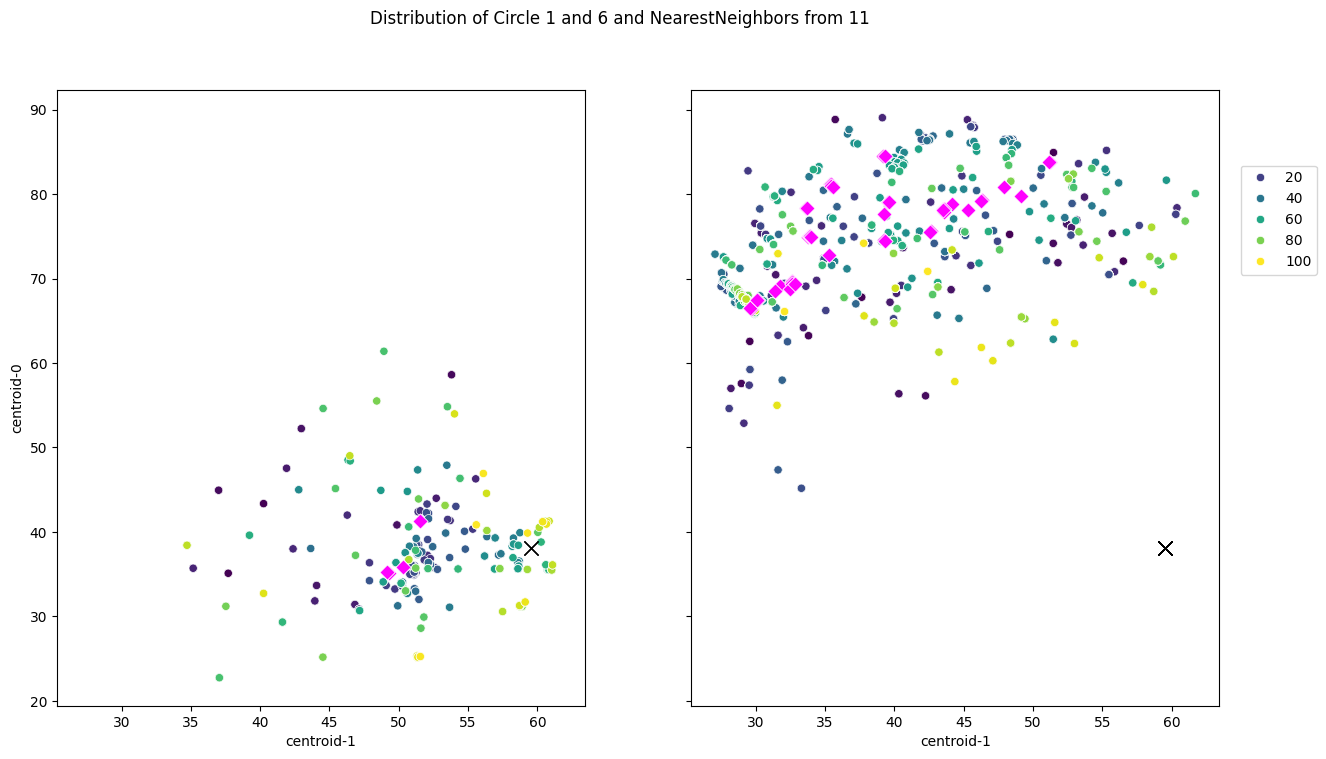

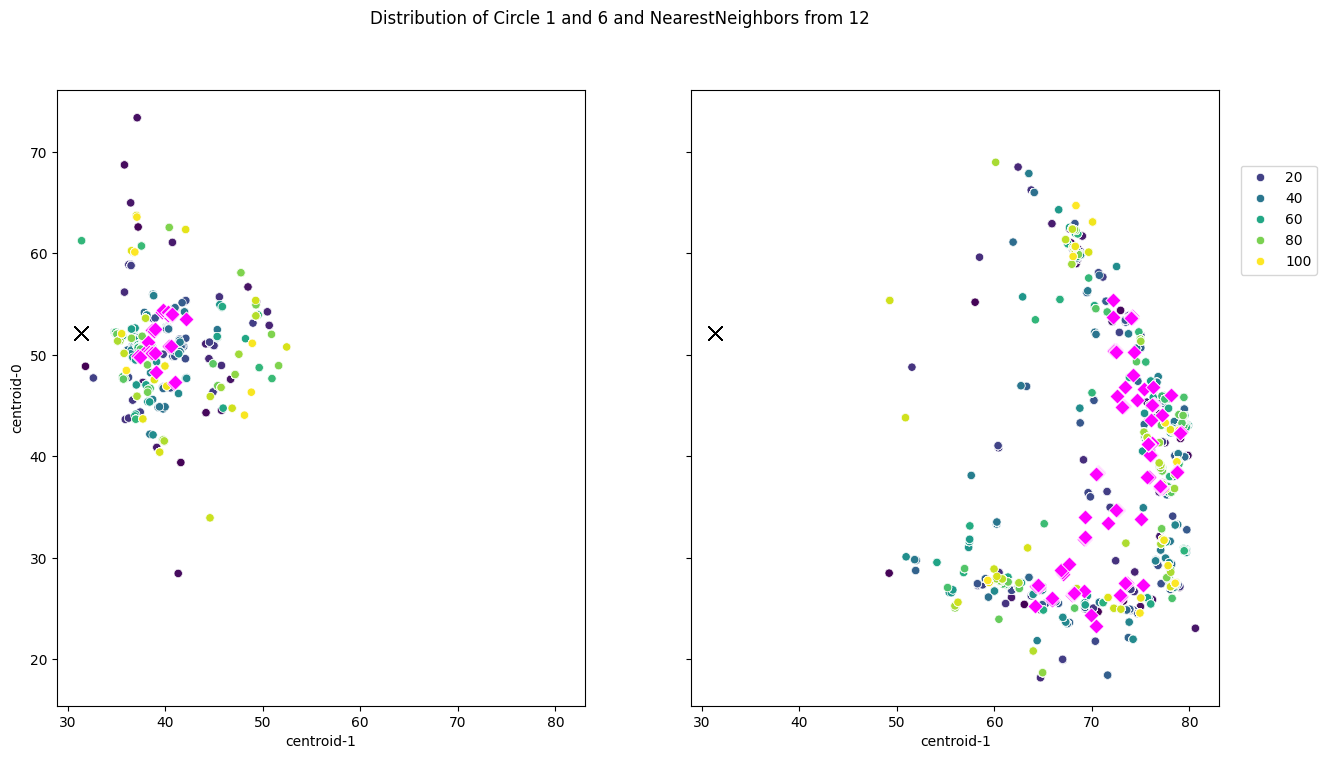

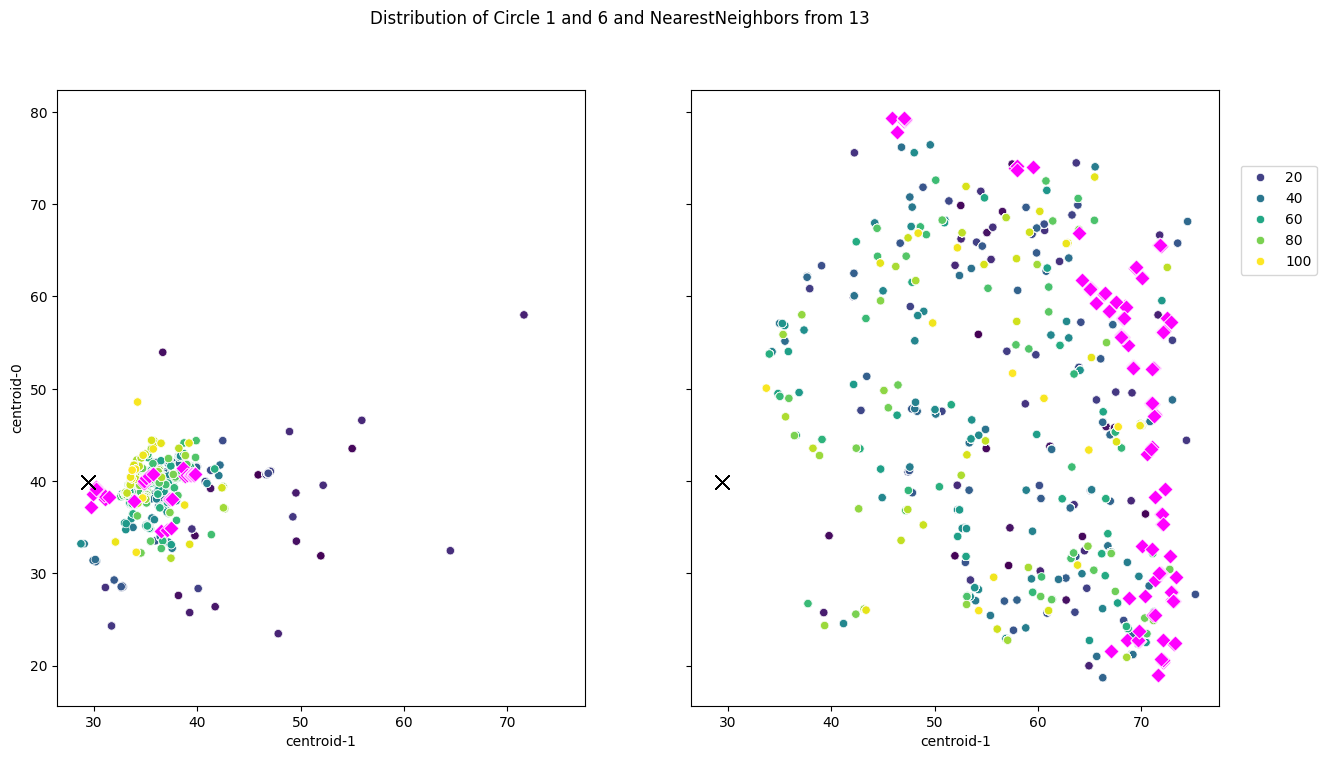

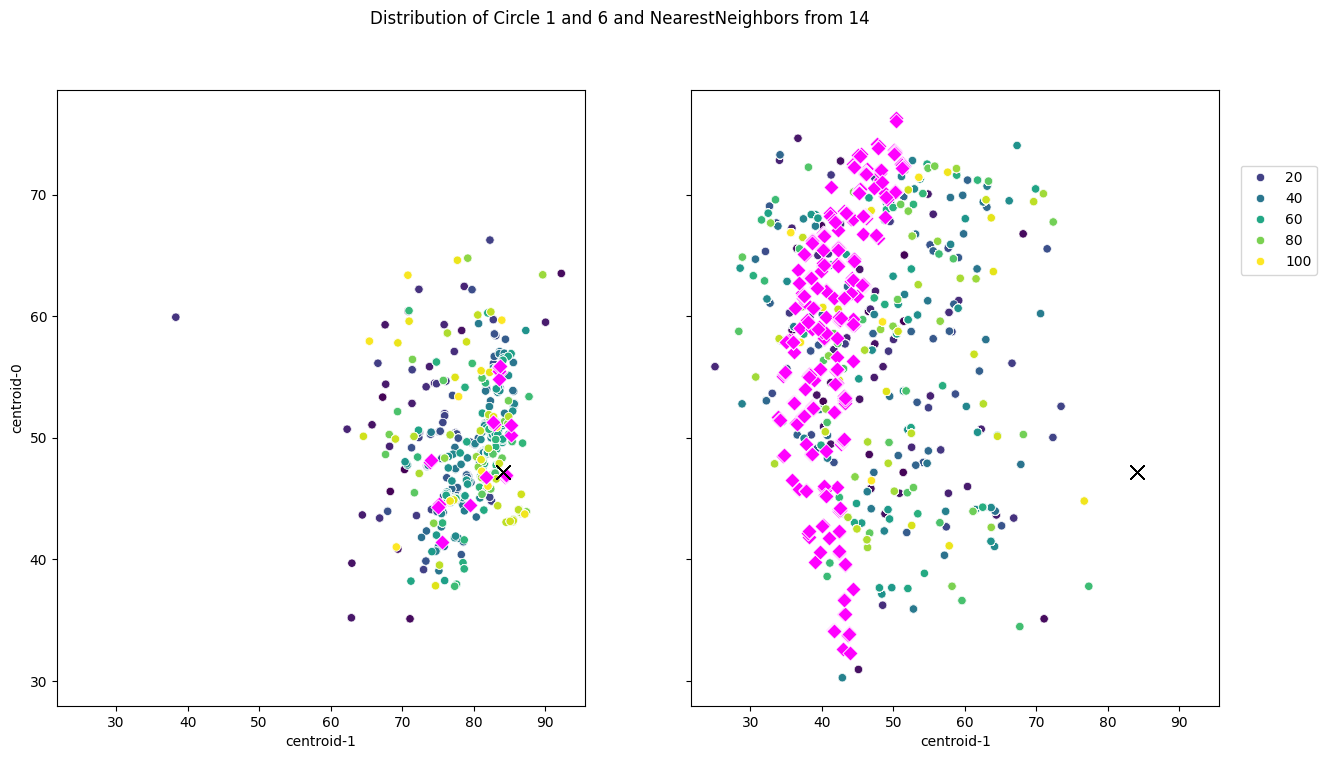

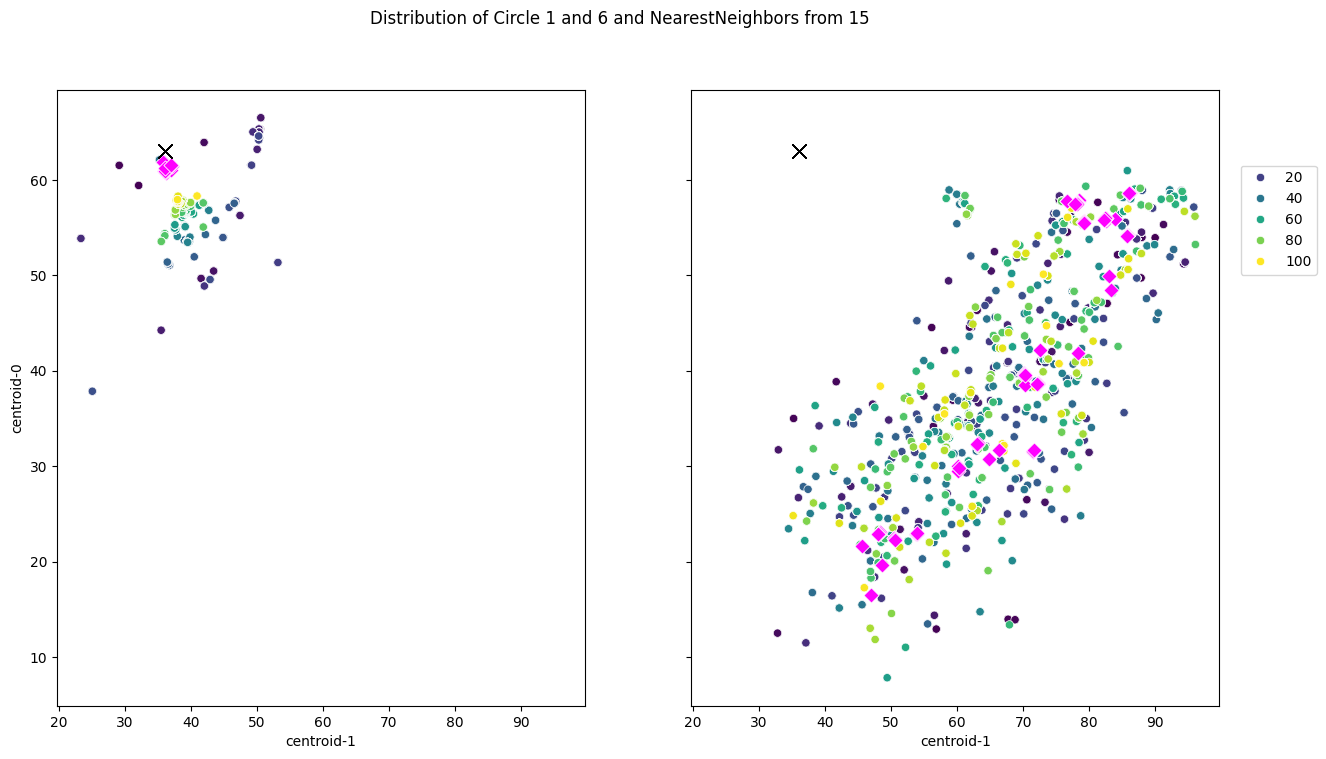

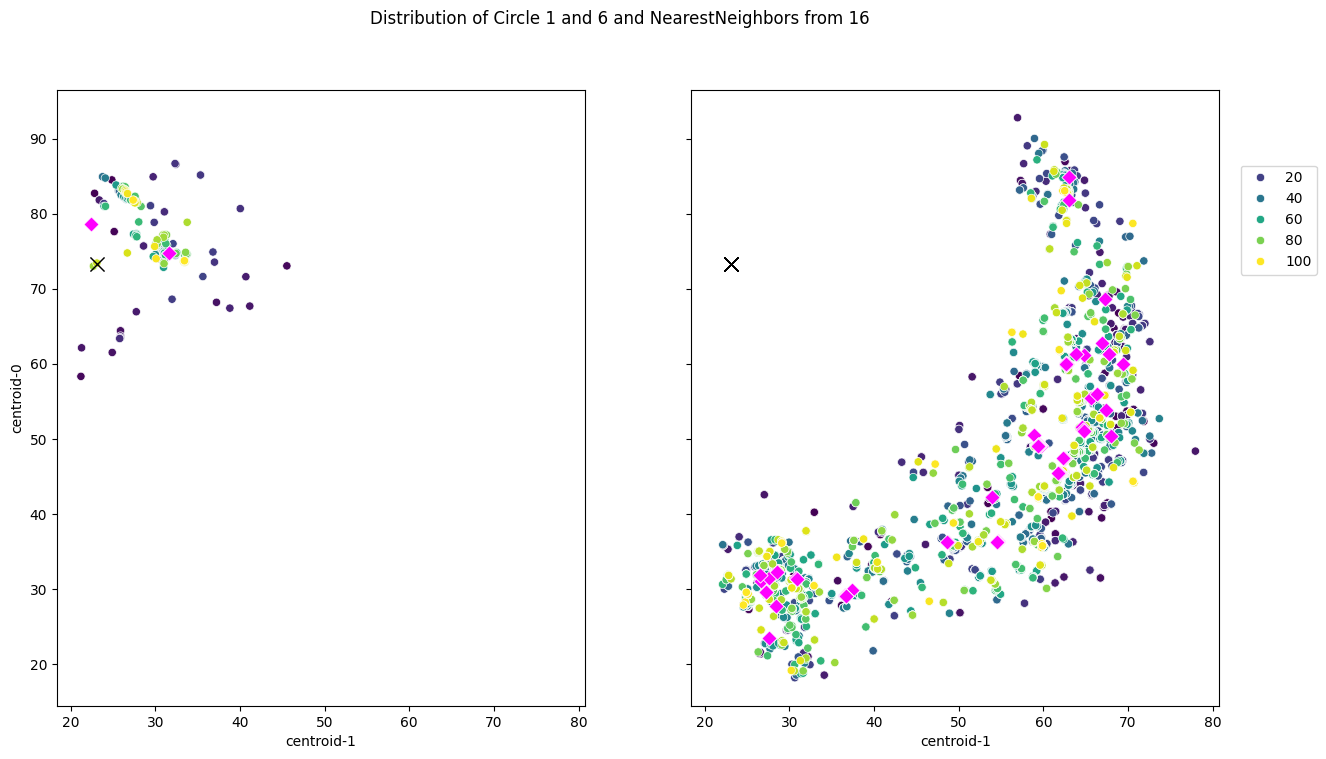

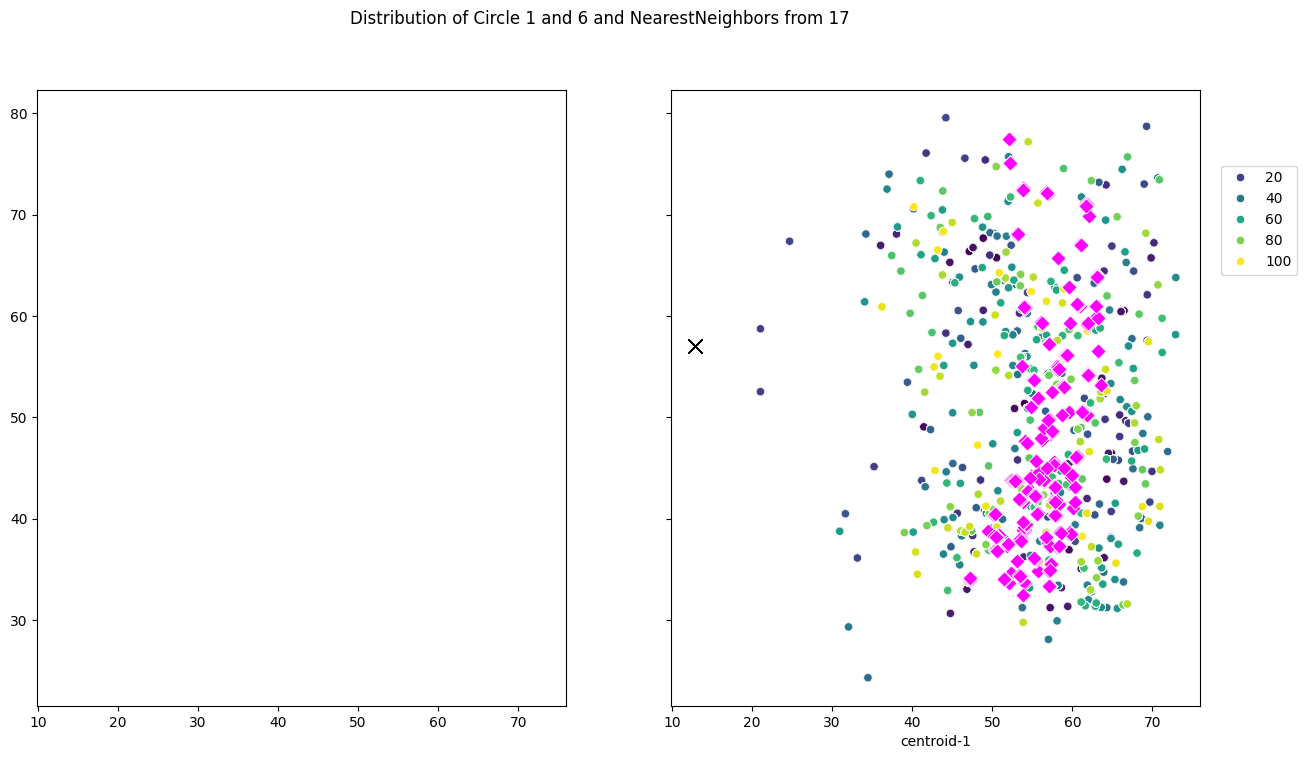

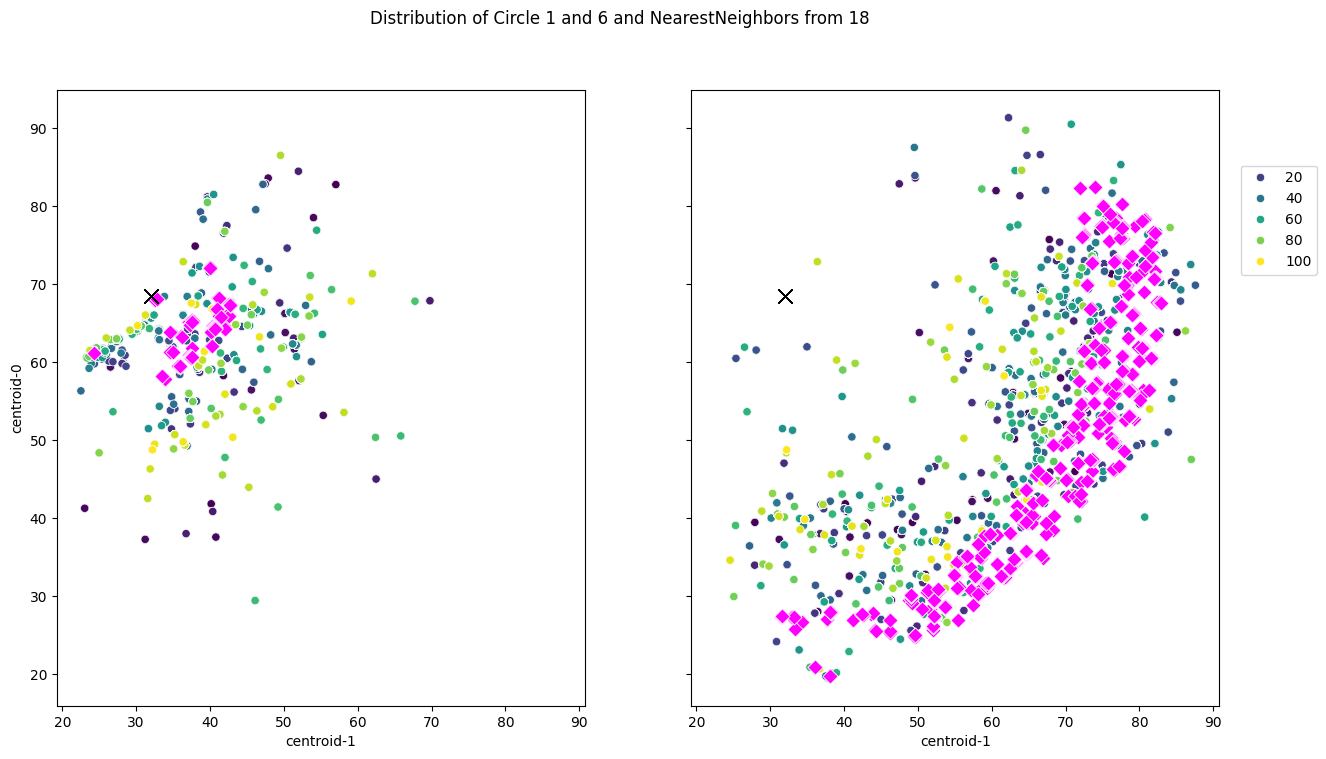

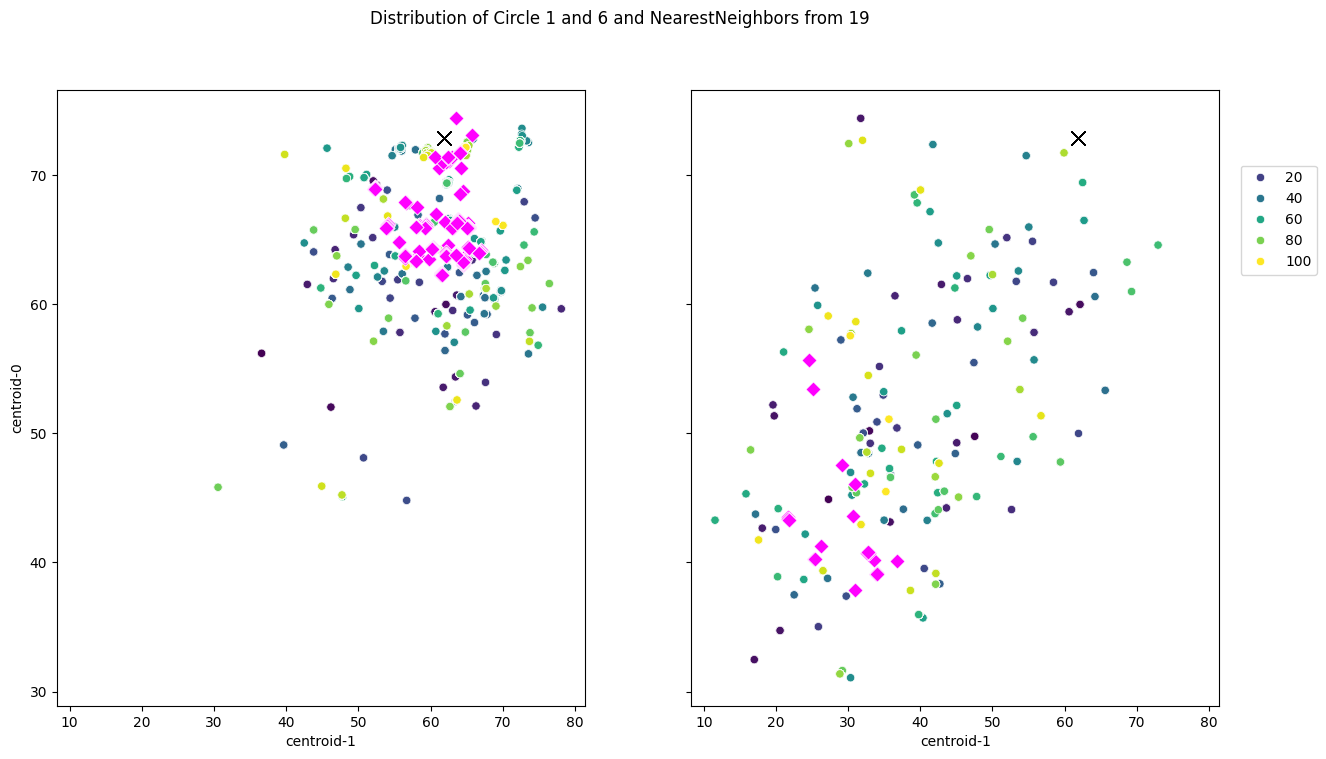

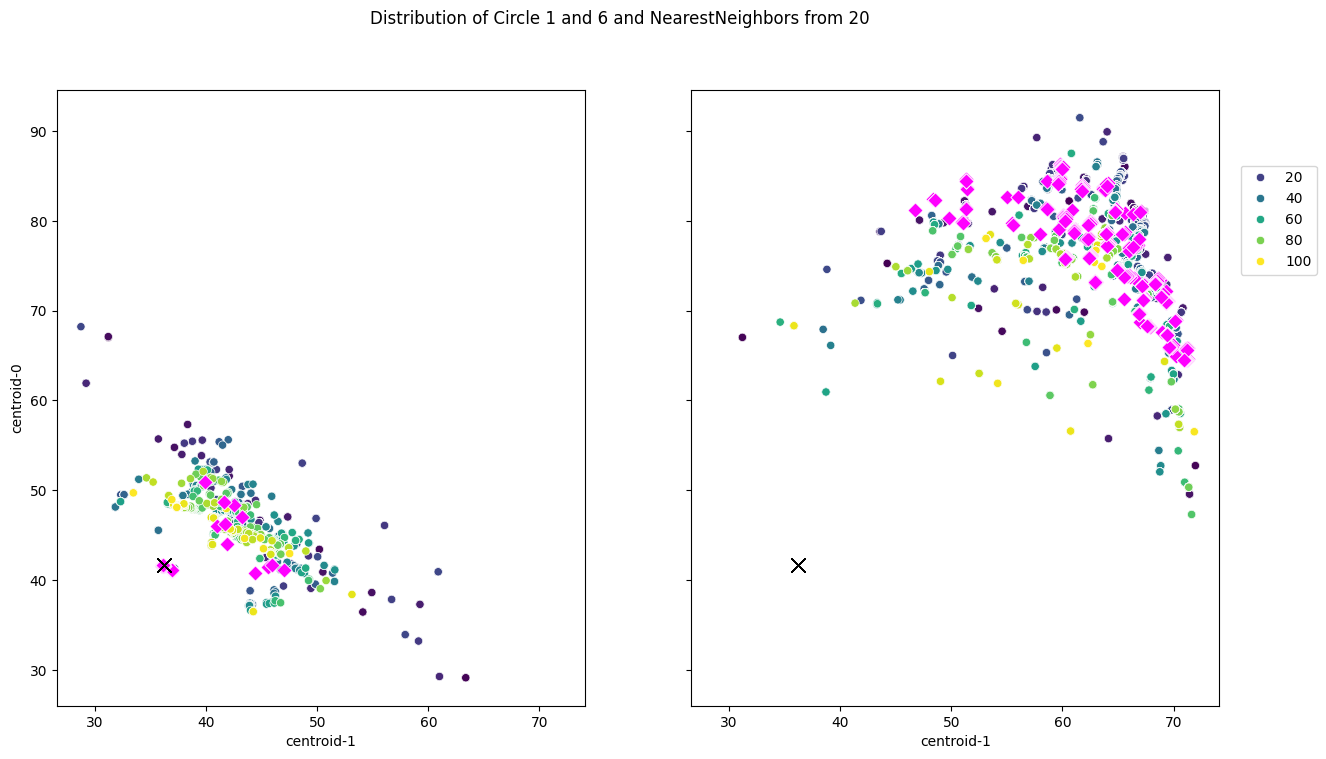

In [75]:
for ident in tqdm(range(len(identifiers))):
    nn_df_1 = nn_df_circle1[nn_df_circle1.Identifier == identifiers[ident]]
    df_C2_1 = df_C2_filtered_Circle1[df_C2_filtered_Circle1.Identifier == identifiers[ident]]
    
    nn_df_6 = nn_df_circle6[nn_df_circle6.Identifier == identifiers[ident]]
    df_C2_6 = df_C2_filtered_Circle6[df_C2_filtered_Circle6.Identifier == identifiers[ident]]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharex=True, sharey=True)
    sns.scatterplot(x=nn_df_1["centroid-1"], y=nn_df_1["centroid-0"], hue=nn_df_1["frame"], palette="viridis", 
                    legend=False, ax=axes[0])
    sns.scatterplot(x=df_C2_1["centroid-1"], y=df_C2_1["centroid-0"], marker="D", color="magenta", s=60, ax=axes[0])
    sns.scatterplot(x=df_C2_1["Wound_coord_X"], y=df_C2_1["Wound_coord_Y"], marker="x", color="black", s=100, ax=axes[0])
    
    sns.scatterplot(x=nn_df_6["centroid-1"], y=nn_df_6["centroid-0"], hue=nn_df_6["frame"], palette="viridis", 
                    legend=True, ax=axes[1])
    sns.scatterplot(x=df_C2_6["centroid-1"], y=df_C2_6["centroid-0"], marker="D", color="magenta", s=60, ax=axes[1])
    sns.scatterplot(x=df_C2_6["Wound_coord_X"], y=df_C2_6["Wound_coord_Y"], marker="x", color="black", s=100, ax=axes[1])
    
    
    plt.legend(loc=(1.04, 0.70))
    fig.suptitle(f"Distribution of Circle 1 and 6 and NearestNeighbors from {ident}") 
    plt.savefig(f"{filepath}\\NN_Circle1_{ident}.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

### Circle 1 - 2

In [ ]:
for ident in tqdm(range(len(identifiers))):
    nn_df_12 = nn_df_circle12[nn_df_circle12.Identifier == identifiers[ident]]
    df_C2_12 = df_C2_filtered_Circle12[df_C2_filtered_Circle12.Identifier == identifiers[ident]]
    
    nn_df_6 = nn_df_circle6[nn_df_circle6.Identifier == identifiers[ident]]
    df_C2_6 = df_C2_filtered_Circle6[df_C2_filtered_Circle6.Identifier == identifiers[ident]]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharex=True, sharey=True)
    sns.scatterplot(x=nn_df_12["centroid-1"], y=nn_df_12["centroid-0"], hue=nn_df_12["frame"], palette="viridis", 
                    legend=False, ax=axes[0])
    sns.scatterplot(x=df_C2_12["centroid-1"], y=df_C2_12["centroid-0"], marker="D", color="magenta", s=60, ax=axes[0])
    sns.scatterplot(x=df_C2_12["Wound_coord_X"], y=df_C2_12["Wound_coord_Y"], marker="x", color="black", s=100, ax=axes[0])
    
    sns.scatterplot(x=nn_df_6["centroid-1"], y=nn_df_6["centroid-0"], hue=nn_df_6["frame"], palette="viridis", 
                    legend=True, ax=axes[1])
    sns.scatterplot(x=df_C2_6["centroid-1"], y=df_C2_6["centroid-0"], marker="D", color="magenta", s=60, ax=axes[1])
    sns.scatterplot(x=df_C2_6["Wound_coord_X"], y=df_C2_6["Wound_coord_Y"], marker="x", color="black", s=100, ax=axes[1])
    
    
    plt.legend(loc=(1.04, 0.70))
    fig.suptitle(f"Distribution of Circle 1+2 and 6 and NearestNeighbors from {ident}")       
    plt.savefig(f"{filepath}\\NN_Circle12_{ident}.tiff", dpi=600, transparent=True, bbox_inches="tight", format="tiff")

### Movie representation of NNs

In [ ]:
if save_overlayNN:
    print("Creating and saving overlay images")
# Inner loop: schreib alle striche pro frame, setze das Bild dann an die richtige frame stelle im Array, bild löschen
    oneframe_lines = np.zeros((1220, 1220))
    linelist = []
    for ident in tqdm(range(len(identifiers))):
        nn_df = nn_df_circle1[nn_df_circle1.Identifier == identifiers[ident]]
        framelist = []
        for f in range(101):#nn_df.frame.unique():
            C1_y = nn_df[nn_df["frame"] == f]["centroid-0"]
            C1_x = nn_df[nn_df["frame"] == f]["centroid-1"]
            C2_y = nn_df[nn_df["frame"] == f]["Particle_C2_Y"]
            C2_x = nn_df[nn_df["frame"] == f]["Particle_C2_X"]
            oneframe = np.zeros((1220, 1220))
    
            for i in range(C1_y.shape[0]):
                try:
                    oneframe_lines = cv2.line(oneframe, (int(C1_x.iloc[i]/0.085), int(C1_y.iloc[i]/0.085)), 
                            (int(C2_x.iloc[i]/0.085), int(C2_y.iloc[i]/0.085)), color = (255, 255, 255), thickness=1, lineType=8)
                except:
                    oneframe_lines = np.zeros((1220, 1220))
            framelist.append(oneframe_lines)
        lines = np.array(framelist[1:])  
        linelist.append(lines)
    
    
    merged_imgs = []
    for number, lbl_img_filtered in tqdm(enumerate(lbl_imgs_filtered)):
        max_img = np.max(lbl_img_filtered[1, 2:11, :, :], axis=0)
        max_img_rep = np.repeat(max_img[np.newaxis, :, :], 100, axis=0)
        merged_img = np.stack((max_img_rep, lbl_img_filtered[0, :, :, :], linelist[number]), axis=0)
        merged_imgs.append(merged_img)
    
    for number, merged_image in tqdm(enumerate(merged_imgs)):
        newpath = filepath + f"/{identifiers[number]}_LabelLines"
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        tiffname = newpath + f"/lines.tiff"
        tfile.imwrite(tiffname, merged_image[:, :, :, :])